# Imports & Data Cleaning:

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import json

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# https://pypi.org/project/pointofview/
# !pip install pointofview
import pointofview as pv

# Sentiment analysis
# !pip install afinn
from afinn import Afinn
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob, Word, Blobber 
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [170]:
# read in individual datasets
train = pd.read_csv('../data/train/train.csv')
test = pd.read_csv('../data/test/test.csv')

# combine the datasets
train['train_test'] = 'train'
test['train_test'] = 'test'
full_data = pd.concat([train, test]).reset_index().drop(columns = 'index')

# import supplementary data, and map values to columns in full data
colors = pd.read_csv('../data/color_labels.csv', index_col = 'ColorID').to_dict().get('ColorName')
colors[0] = 'blank'

full_data['Color1'] = full_data['Color1'].map(colors)
full_data['Color2'] = full_data['Color2'].map(colors)
full_data['Color3'] = full_data['Color3'].map(colors)

breeds = pd.read_csv('../data/breed_labels.csv', index_col = 'BreedID', usecols = [0,2]).to_dict().get('BreedName')
breeds[0] = 'blank'
full_data['Breed1'] = full_data['Breed1'].map(breeds)
full_data['Breed2'] = full_data['Breed2'].map(breeds)

states = pd.read_csv('../data/state_labels.csv', index_col = 'StateID').to_dict().get('StateName')
full_data['State'] = full_data['State'].map(states)

full_data['Type'] = full_data['Type'].map(lambda x: 'Dog' if x == 1 else 'Cat')

full_data['FurLength'] = full_data['FurLength'].map({1 : 'Short',
                                                     2 : 'Medium',
                                                     3 : 'Long',
                                                     0 : 'Not Specified'})

full_data['Vaccinated'] = full_data['Vaccinated'].map({1 : 'Yes',
                                                       2 : 'No', 
                                                       3 : 'Not Sure'})

full_data['Health'] = full_data['Health'].map({1 : 'Healthy',
                                               2 : 'Minor Injury',
                                               3 : 'Serious Injury',
                                               0 : 'Not Sure'})

full_data['Dewormed'] = full_data['Dewormed'].map({1 : 'Yes',
                                                   2 : 'No', 
                                                   3 : 'Not Sure'})

full_data['Sterilized'] = full_data['Sterilized'].map({1 : 'Yes',
                                               2 : 'No', 
                                               3 : 'Not Sure'})

full_data['MaturitySize'] = full_data['MaturitySize'].map({1 : 'Small',
                                                   2 : 'Medium',
                                                   3 : 'Large',
                                                   4 : 'Extra Large',
                                                   0 : 'Not Specified'})

full_data['Gender'] = full_data['Gender'].map({1 : 'Male',
                                               2 : 'Female',
                                               3 : 'Multiple'})

In [171]:
full_data.isna().sum()

Type                0
Name             1668
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        13
PetID               0
PhotoAmt            0
AdoptionSpeed    3972
train_test          0
dtype: int64

In [172]:
full_data['Name'] = full_data['Name'].fillna('blank')

In [173]:
full_data['Description'] = full_data['Description'].fillna('blank')

In [174]:
train.shape

(14993, 25)

In [175]:
test.shape

(3972, 24)

In [176]:
full_data.shape

(18965, 25)

# Feature Engineering

In [177]:
len(full_data)

18965

In [178]:
# coat combinations
full_data['coat_combo'] = [(full_data['Color1'][i] + full_data['Color2'][i] + full_data['Color3'][i])\
                 .replace('NA', '') for i in range(len(full_data['Color1']))] 

In [179]:
# solid color or multi_color
full_data['solid_color'] = ['Solid' if full_data['Color2'][i] == 'NA' and full_data['Color3'][i] == 'NA'
                                else 'Multi-Colored' for i in range(len(full_data))] 

In [181]:
# word counts for description column
def word_count(text):
    count = 0
    for word in str(text).split():
        count += 1
    return count

full_data['description_word_count'] = [word_count(full_data['Description'][i]) for i in range(len(full_data['Description']))]

In [182]:
# get pov of description
# https://pypi.org/project/pointofview/

full_data['desc_pov']= [pv.get_text_pov(str(x)) for x in full_data['Description']]
full_data['desc_pov'] = full_data['desc_pov'].fillna('not determined')

###### Textblob

In [183]:
len(full_data[full_data['train_test'] == 'train'])

14993

In [184]:
round(TextBlob(full_data['Description'][0]).polarity, 4)

0.1304

In [185]:
round(TextBlob(full_data['Description'][0]).subjectivity, 4)

0.4071

In [186]:
full_data['textblob_polarity'] = [round(TextBlob(str(x)).polarity, 4) for x in full_data['Description']]
full_data['textblob_subjectivity'] = [round(TextBlob(str(x)).subjectivity, 4) for x in full_data['Description']]

In [187]:
textblob_polarity = [round(TextBlob(str(x)).polarity, 4)
                     for x in full_data[full_data['train_test'] == 'train']['Description']]
textblob_subjectivity = [round(TextBlob(str(x)).subjectivity, 4)
                         for x in full_data[full_data['train_test'] == 'train']['Description']]

In [188]:
polarity_category = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' 
                      for score in textblob_polarity]
subjectivity_category = ['subjective' if score > .5 else 'objective' if score < .5 else 'neutral' 
                      for score in textblob_subjectivity]

In [189]:
textblob_df = pd.DataFrame([list(full_data[full_data['train_test'] == 'train']['AdoptionSpeed'].astype(int)), 
                   textblob_polarity, polarity_category, textblob_subjectivity, subjectivity_category]).T
textblob_df.columns = ['AdoptionSpeed', 'polarity', 'polarity_category', 'subjectivity', 'subjectivity_category']
textblob_df['polarity'] = textblob_df['polarity'].astype('float')
textblob_df['subjectivity'] = textblob_df['subjectivity'].astype('float')
textblob_df.groupby(by=['AdoptionSpeed']).describe()

polarity                                                         \
                 count      mean       std   min       25%      50%       75%   
AdoptionSpeed                                                                   
0                410.0  0.178961  0.188983 -0.50  0.028650  0.14640  0.270075   
1               3090.0  0.188214  0.175948 -0.75  0.060075  0.17865  0.296650   
2               4037.0  0.202361  0.175543 -0.75  0.078800  0.19410  0.313300   
3               3259.0  0.206833  0.174527 -0.60  0.080050  0.20000  0.321400   
4               4197.0  0.208584  0.195385 -1.00  0.065500  0.20000  0.333300   

                      subjectivity                                            \
                  max        count      mean       std  min     25%      50%   
AdoptionSpeed                                                                  
0              0.7500        410.0  0.474067  0.233606  0.0  0.3827  0.48020   
1              1.0000       3090.0  0.488116  0.218311  0.0  0.4000  0.51575   
2              1.0000       4037.0  0.498351  0.210040  0.0  0.4167  0.51880   
3              1.0000       3259.0  0.502367  0.204186  0.0  0.4219  0.52180   
4              0.9375       4197.0  0.509142  0.218753  0.0  0.4194  0.53010   

                              
                    75%  max  
AdoptionSpeed                 
0              0.615575  1.0  
1              0.618875  1.0  
2              0.625000  1.0  
3              0.625000  1.0  
4              0.634200  1.0

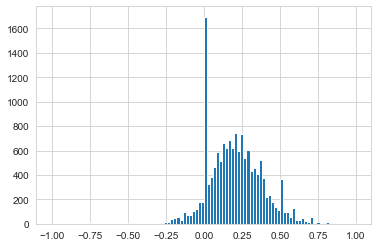

In [190]:
plt.hist(textblob_df['polarity'], bins = 100);

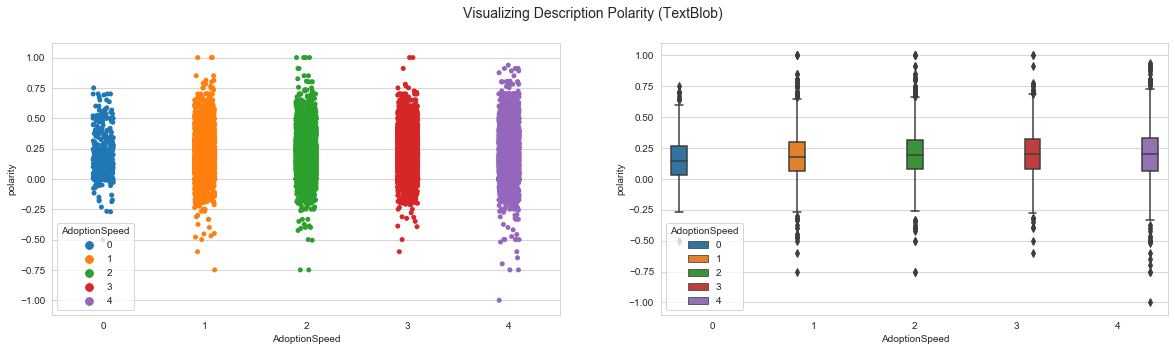

In [191]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
sns.stripplot(data=textblob_df, x='AdoptionSpeed', y="polarity", 
                   hue='AdoptionSpeed', order = [0,1,2,3,4], hue_order = [0,1,2,3,4], ax=ax1)
sns.boxplot(data=textblob_df, x='AdoptionSpeed', y="polarity", 
                   hue='AdoptionSpeed', order = [0,1,2,3,4], hue_order = [0,1,2,3,4], ax=ax2)
f.suptitle('Visualizing Description Polarity (TextBlob)', fontsize=14);

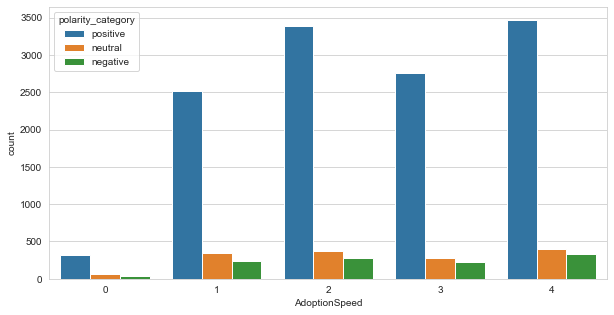

In [192]:
plt.figure(figsize = (10,5))
sns.countplot(x = 'AdoptionSpeed', hue = 'polarity_category', order = [0,1,2,3,4], data = textblob_df);

(array([1259.,  206.,  641., 1239., 3022., 4177., 2508., 1095.,  465.,
         381.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

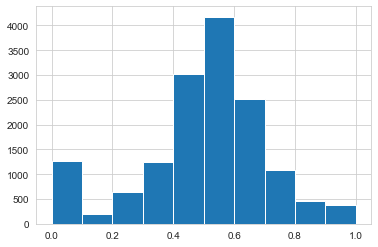

In [193]:
plt.hist(textblob_df['subjectivity'])

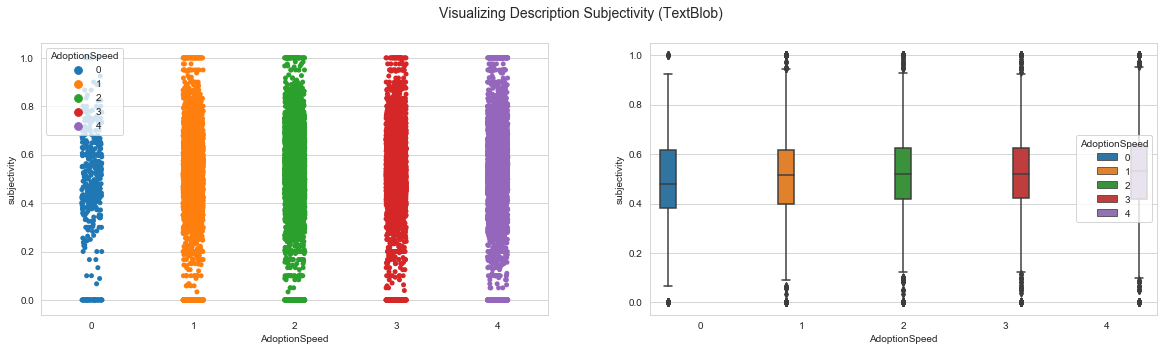

In [194]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
sns.stripplot(data = textblob_df, x = 'AdoptionSpeed', y = 'subjectivity', 
                   hue = 'AdoptionSpeed', order = [0,1,2,3,4], hue_order = [0,1,2,3,4], ax = ax1)
sns.boxplot(data = textblob_df, x = 'AdoptionSpeed', y = 'subjectivity', 
                   hue = 'AdoptionSpeed', order = [0,1,2,3,4], hue_order = [0,1,2,3,4], ax = ax2)
f.suptitle('Visualizing Description Subjectivity (TextBlob)', fontsize=14);

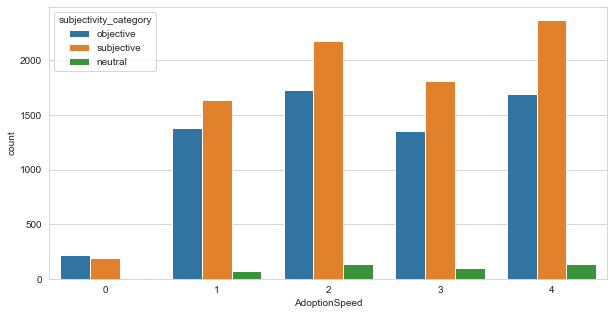

In [195]:
plt.figure(figsize = (10,5))
sns.countplot(x = 'AdoptionSpeed', hue = 'subjectivity_category', order = [0,1,2,3,4], data = textblob_df);

###### AFINN

In [196]:
af = Afinn()

In [197]:
full_data['afinn_sentiment'] = [af.score(str(x)) for x in full_data['Description']]


In [198]:
# # compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(str(x)) for x in full_data['Description']]
sentiment_category = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' 
                      for score in sentiment_scores]

# sentiment statistics per news category
df = pd.DataFrame([list(full_data[full_data['train_test'] == 'train']['AdoptionSpeed'].astype(int)), sentiment_scores, sentiment_category]).T
df.columns = ['Speed', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df['sentiment_score'].astype('float')
df.groupby(by=['Speed']).describe()

sentiment_score                                                 
                count      mean       std   min  25%  50%   75%    max
Speed                                                                 
0               410.0  6.590244  6.807726 -17.0  1.0  5.0  10.0   43.0
1              3090.0  7.545955  7.640599 -11.0  2.0  6.0  11.0   60.0
2              4037.0  7.987862  8.251023 -26.0  2.0  6.0  11.0   73.0
3              3259.0  8.343971  8.763579 -20.0  3.0  7.0  12.0   98.0
4              4197.0  7.399095  7.887020 -28.0  2.0  6.0  11.0  101.0

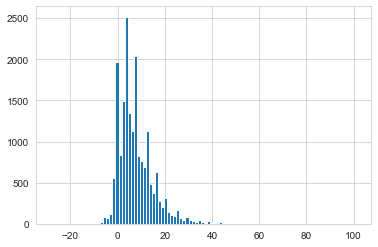

In [199]:
plt.hist(df['sentiment_score'], bins = 100);

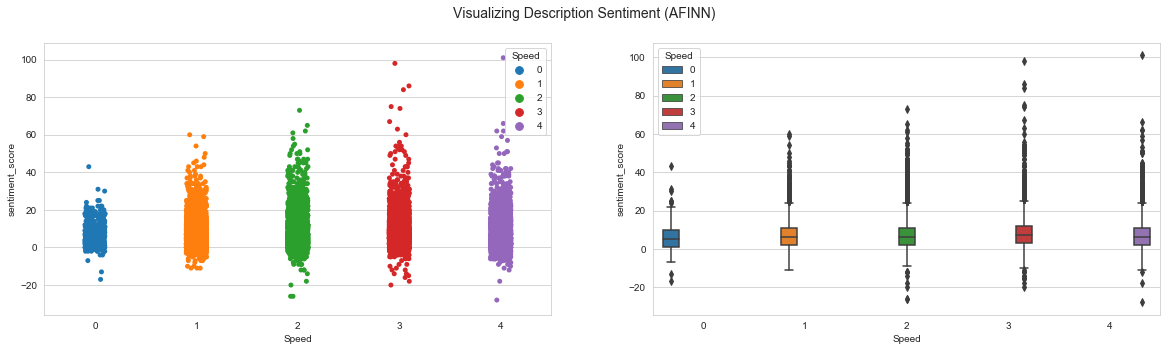

In [200]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
sns.stripplot(x='Speed', y="sentiment_score", 
                   hue='Speed', order = [0,1,2,3,4], hue_order = [0,1,2,3,4], data=df, ax=ax1)
sns.boxplot(x='Speed', y="sentiment_score", 
                 hue='Speed', order = [0,1,2,3,4], hue_order = [0,1,2,3,4], data=df, ax=ax2)
f.suptitle('Visualizing Description Sentiment (AFINN)', fontsize=14);

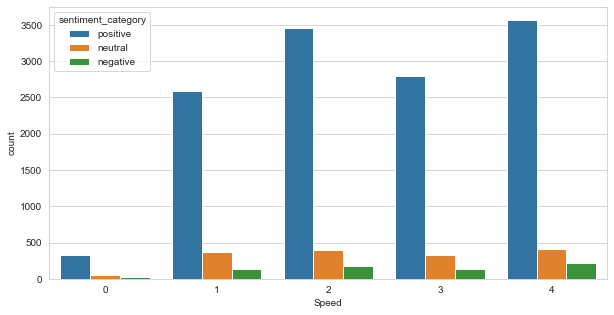

In [201]:
plt.figure(figsize = (10,5))
sns.countplot(x="Speed", hue="sentiment_category", order = [0,1,2,3,4],
                    data=df);



###### VADER

In [202]:
sia = SentimentIntensityAnalyzer()

sia.polarity_scores(train['Description'][1700])

{'neg': 0.0, 'neu': 0.499, 'pos': 0.501, 'compound': 0.9524}

In [203]:
full_data['vader_neg_sentiment'] = [sia.polarity_scores(str(x))['neg'] for x in full_data['Description']]
full_data['vader_neu_sentiment'] = [sia.polarity_scores(str(x))['neu'] for x in full_data['Description']]
full_data['vader_pos_sentiment'] = [sia.polarity_scores(str(x))['pos'] for x in full_data['Description']]
full_data['vader_comp_sentiment'] = [sia.polarity_scores(str(x))['compound'] for x in full_data['Description']]


In [204]:
dicts = []    

for row in full_data[full_data['train_test'] == 'train']['Description']:   #loops through the tweets individual tweets in the corpus
    scores = sia.polarity_scores(str(row))   #gets the sentiment scores for each tweet
    scores['description'] = row #puts tweets in a 'text' column
    dicts.append(scores)  #adds scores & text to empty dictionary


vader_df = pd.DataFrame(dicts)   #makes dataframe from empty dictionary
vader_df['AdoptionSpeed'] = full_data[full_data['train_test'] == 'train']['AdoptionSpeed'].astype(int)

vader_df['compound_category'] = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in vader_df['compound']]
vader_df.head()


,neg,neu,pos,compound,description,AdoptionSpeed,compound_category
0,0.000,0.745,0.255,0.9552,Nibble is a 3+ month old ball of cuteness. He ...,2,positive
1,0.149,0.723,0.129,0.1280,I just found it alone yesterday near my apartm...,0,positive
2,0.095,0.706,0.200,0.7650,Their pregnant mother was dumped by her irresp...,3,positive
3,0.000,0.483,0.517,0.9538,"Good guard dog, very alert, active, obedience ...",2,positive
4,0.000,0.635,0.365,0.9880,This handsome yet cute boy is up for adoption....,2,positive


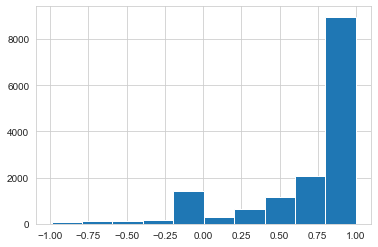

In [205]:
plt.hist(vader_df['compound']);

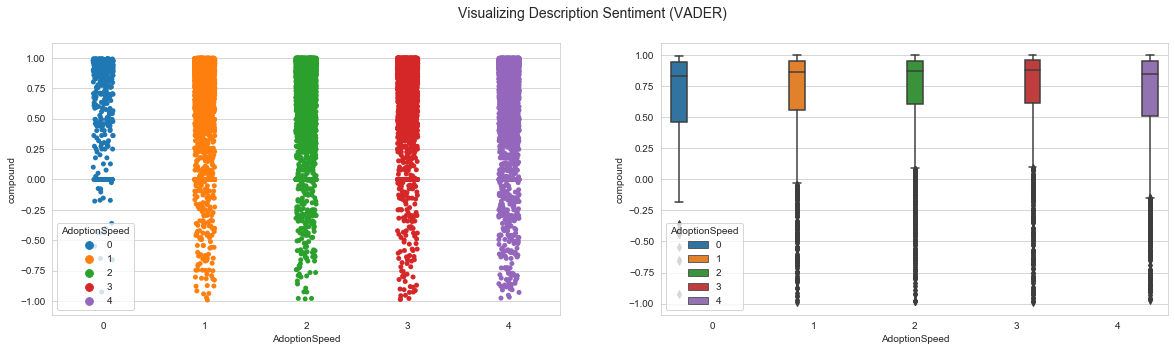

In [206]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
sns.stripplot(x = 'AdoptionSpeed', y = 'compound', 
                   hue = 'AdoptionSpeed', order = [0,1,2,3,4], hue_order = [0,1,2,3,4], data = vader_df, ax=ax1)
sns.boxplot(x = 'AdoptionSpeed',  y= 'compound', 
                 hue='AdoptionSpeed', order = [0,1,2,3,4], hue_order = [0,1,2,3,4], data=vader_df, ax=ax2)
f.suptitle('Visualizing Description Sentiment (VADER)', fontsize=14);

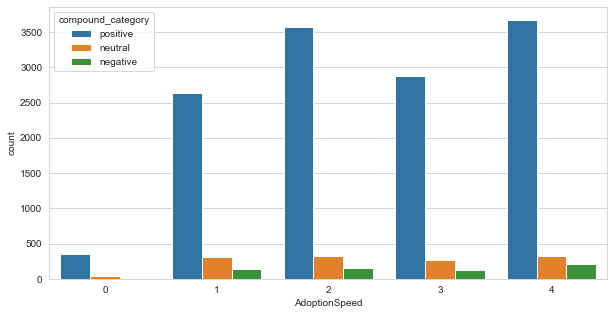

In [207]:
plt.figure(figsize = (10,5))
sns.countplot(x="AdoptionSpeed", hue="compound_category", order = [0,1,2,3,4],
                    data=vader_df);

In [208]:
# create lists for data from image metadata to be added to dataframe
image_path = []
dom_description = []
dom_score = []
dom_red = []
dom_blue = []
dom_green = []
dom_color_score = []
dom_color_pixel_fraction = []
crop_x = []
crop_y = []
has_metadata = []

# loop through all rows
for i in range(len(full_data)):
    
    # select the pet id
    pet_id = full_data.iloc[i, full_data.columns.get_loc('PetID')]
    

    # for pets in training set
    if full_data.iloc[i, full_data.columns.get_loc('train_test')] == 'train':
        
        # get image path
        image = f'../data/train_images/{pet_id}-1.jpg'
        image_path.append(image)
        
        #check for metadata file
        try:
            file = open(f'../data/train_metadata/{pet_id}-1.json')
            data = json.load(file)
            
            data_keys = list(data.keys())
            
            if 'labelAnnotations' in data_keys:
                dom_description.append(data['labelAnnotations'][0].get('description'))
                dom_score.append(data['labelAnnotations'][0].get('score'))
            else:
                dom_description.append('blank')
                dom_score.append(0)
            
            if 'imagePropertiesAnnotation' in data_keys:
                dom_red.append(data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color'].get('red'))
                dom_blue.append(data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color'].get('green'))
                dom_green.append(data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color'].get('blue'))
                dom_color_score.append(data['imagePropertiesAnnotation']['dominantColors']['colors'][0].get('score'))
                dom_color_pixel_fraction.append(data['imagePropertiesAnnotation']['dominantColors']['colors'][0].get('pixelFraction'))
            else:
                dom_red.append(0)
                dom_blue.append(0)
                dom_green.append(0)
                dom_color_score.append(0)
                dom_color_pixel_fraction.append(0)
                 
            if 'cropHintsAnnotation' in data_keys:
                crop_x.append(data['cropHintsAnnotation']['cropHints'][0].get('boundingPoly')['vertices'][1].get('x'))
                crop_y.append(data['cropHintsAnnotation']['cropHints'][0].get('boundingPoly')['vertices'][3].get('y'))
            else:
                crop_x.append(0)
                crop_y.append(0)
            
            has_metadata.append(1)

            file.close
        
        # if no file, impute
        except FileNotFoundError:
            dom_description.append('blank')
            dom_score.append(0)
            dom_red.append(0)
            dom_blue.append(0)
            dom_green.append(0)
            dom_color_score.append(0)
            dom_color_pixel_fraction.append(0)
            crop_x.append(0)
            crop_y.append(0)
            has_metadata.append(0)


    # for pets in test set:
    else: 
        
        # get image path
        image = f'../data/test_images/{pet_id}-1.jpg'
        image_path.append(image)
        
        # check for metadata file
        try: 
            file = open(f'../data/test_metadata/{pet_id}-1.json')
            data = json.load(file)

            data_keys = list(data.keys())
            
            if 'labelAnnotations' in data_keys:
                dom_description.append(data['labelAnnotations'][0].get('description'))
                dom_score.append(data['labelAnnotations'][0].get('score'))
            else:
                dom_description.append('blank')
                dom_score.append(0)
            
            if 'imagePropertiesAnnotation' in data_keys:
                dom_red.append(data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color'].get('red'))
                dom_blue.append(data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color'].get('green'))
                dom_green.append(data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color'].get('blue'))
                dom_color_score.append(data['imagePropertiesAnnotation']['dominantColors']['colors'][0].get('score'))
                dom_color_pixel_fraction.append(data['imagePropertiesAnnotation']['dominantColors']['colors'][0].get('pixelFraction'))
            else:
                dom_red.append(0)
                dom_blue.append(0)
                dom_green.append(0)
                dom_color_score.append(0)
                dom_color_pixel_fraction.append(0)
                 
            if 'cropHintsAnnotation' in data_keys:
                crop_x.append(data['cropHintsAnnotation']['cropHints'][0].get('boundingPoly')['vertices'][1].get('x'))
                crop_y.append(data['cropHintsAnnotation']['cropHints'][0].get('boundingPoly')['vertices'][3].get('y'))
            else:
                crop_x.append(0)
                crop_y.append(0)
            
            has_metadata.append(1)

            file.close
        
        # if no file, impute
        except FileNotFoundError:
            
            dom_description.append('blank')
            dom_score.append(0)
            dom_red.append(0)
            dom_blue.append(0)
            dom_green.append(0)
            dom_color_score.append(0)
            dom_color_pixel_fraction.append(0)
            crop_x.append(0)
            crop_y.append(0)
            has_metadata.append(0)

# add columns to dataframe
full_data['image_path'] = image_path
full_data['dom_description'] = dom_description
full_data['dom_score'] = dom_score 
full_data['dom_red'] = dom_red 
full_data['dom_blue'] = dom_blue 
full_data['dom_green'] = dom_green 
full_data['dom_color_score'] = dom_color_score 
full_data['dom_color_pixel_fraction'] = dom_color_pixel_fraction
full_data['crop_x'] = crop_x
full_data['crop_y'] = crop_y
full_data['has_metadata'] = has_metadata 

In [209]:
def show_image(path):
    plt.figure(figsize = (10,10))
    image = plt.imshow(plt.imread(path))
    return image

In [210]:
def show_pet(i):
    name = f"Name: {full_data['Name'][i]}"
    age = f"Age: {full_data['Age'][i]} months"
    gender = f"Gender: {full_data['Gender'][i]}"
    health = f"Health: {full_data['Health'][i]}"
    vaccinated = f"Vaccinated: {full_data['Vaccinated'][i]}"
    dewormed = f"Dewormed: {full_data['Dewormed'][i]}"
    sterilized = f"Spayed/Neutered: {full_data['Sterilized'][i]}"
    fee = f"Fee: {full_data['Fee'][i]}"
    description =f"Description: {full_data['Description'][i]}"
    plt.figure(figsize = (10,10))
    image = plt.imshow(plt.imread(full_data['image_path'][i]))
    return name, age, gender, health, vaccinated, dewormed, sterilized, fee, description, image

In [211]:
full_data.iloc[18,:]

Type                                                                      Dog
Name                                                                   Beauty
Age                                                                         2
Breed1                                                            Mixed Breed
Breed2                                                                  blank
Gender                                                                 Female
Color1                                                                  Black
Color2                                                                  blank
Color3                                                                  blank
MaturitySize                                                           Medium
FurLength                                                               Short
Vaccinated                                                                 No
Dewormed                                                        

('Name: Beauty',
 'Age: 2 months',
 'Gender: Female',
 'Health: Healthy',
 'Vaccinated: No',
 'Dewormed: Yes',
 'Spayed/Neutered: No',
 'Fee: 0',
 "Description: This cutie dumped by it's owner at the market and almost kill by the car, after kicking by the guy, trying to hide herself for safe under the car while the driver is ready to run, ran to her hit on the car to notice the driver stop before i pulled her out and safe her. Luckily the kindness factory guy is allowed me to keep her there, cause my shop is full with 19 dogs and cats, situation not allow me to take in more, due to my work i could only feed her once a day and clean her cage. She's a black beauty, about 2months +, if anyone able to give her a forever home, please do directly contact with me or sms me,thanks! And PLEASE the more i can rehome, the more i can rescue!",
 <matplotlib.image.AxesImage at 0x1a28183cd0>)

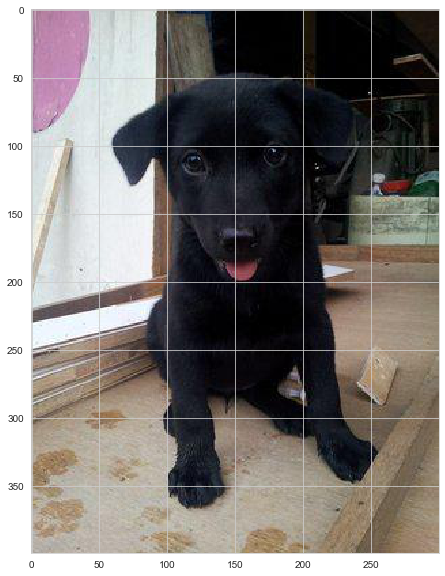

In [224]:
# enter a number from 0 to 18965
show_pet(18)

In [213]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18965 entries, 0 to 18964
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Type                      18965 non-null  object 
 1   Name                      18965 non-null  object 
 2   Age                       18965 non-null  int64  
 3   Breed1                    18965 non-null  object 
 4   Breed2                    18965 non-null  object 
 5   Gender                    18965 non-null  object 
 6   Color1                    18965 non-null  object 
 7   Color2                    18965 non-null  object 
 8   Color3                    18965 non-null  object 
 9   MaturitySize              18965 non-null  object 
 10  FurLength                 18965 non-null  object 
 11  Vaccinated                18965 non-null  object 
 12  Dewormed                  18965 non-null  object 
 13  Sterilized                18965 non-null  object 
 14  Health

In [214]:
full_data.isna().sum()

Type                           0
Name                           0
Age                            0
Breed1                         0
Breed2                         0
Gender                         0
Color1                         0
Color2                         0
Color3                         0
MaturitySize                   0
FurLength                      0
Vaccinated                     0
Dewormed                       0
Sterilized                     0
Health                         0
Quantity                       0
Fee                            0
State                          0
RescuerID                      0
VideoAmt                       0
Description                    0
PetID                          0
PhotoAmt                       0
AdoptionSpeed               3972
train_test                     0
coat_combo                     0
solid_color                    0
description_word_count         0
desc_pov                       0
textblob_polarity              0
textblob_s

In [223]:
# full_data.to_csv('../data/full_data.csv')

# EDA 

In [48]:
train = full_data[full_data['train_test'] == 'train'].copy()

In [49]:
train.shape

(14993, 44)

In [50]:
def counts(data, column):
    return data[column].value_counts()

def counts_pct(data, column):
    return data[column].value_counts(normalize = True)

def countplot(data, column, col_label):
    plt.figure(figsize = (15, 5))
    countplot = sns.countplot(data = data, x = column, hue = 'AdoptionSpeed')
    plt.title(f'Adoption Speed by {col_label}', size = 20)
    plt.xlabel(f'{col_label}', size = 15)
    plt.ylabel('Count', size = 15)
    plt.tight_layout;
    return countplot

def countplot_type(data, column, col_label):
    plt.figure(figsize = (15, 5))
    countplot_type = sns.catplot(data = data, x = column,  hue = 'AdoptionSpeed', col = 'Type', kind = 'count')
    (countplot_type.set_axis_labels(col_label, "Count")
      .set_titles(f'Adoption Speed by {col_label} for ' + "{col_name}s", size = 13)
      .despine(left=True)) 
    plt.tight_layout;
    return countplot_type

def crosstab(data, column):
    return pd.crosstab(data[column], data['AdoptionSpeed'], normalize = 'index')

def crosstab_type(data, column):
    return pd.crosstab([data['Type'], data[column]], data['AdoptionSpeed'], normalize = 'index')

def eda(data, column, col_name):
    return counts(data, column), counts_pct(data, column), crosstab(data, column), crosstab_type(data, column), countplot(data, column, col_name), countplot_type(data, column, col_name)
 
    

###### What is the train_test split?

In [254]:
full_data['train_test'].value_counts(normalize = True)

train    0.790562
test     0.209438
Name: train_test, dtype: float64

> We have about a 79/21 train-test split.

###### What is the distribution of the target variable, ```AdoptionSpeed```?

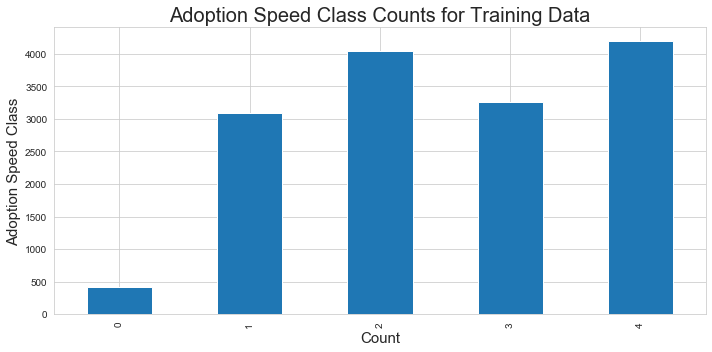

In [294]:
plt.figure(figsize = (10,5))
train['AdoptionSpeed'].value_counts().sort_index().plot(kind = 'bar');
plt.plot
plt.title('Adoption Speed Class Counts for Training Data', size = 20)
plt.xlabel('Count', size = 15)
plt.ylabel('Adoption Speed Class', size = 15)
plt.tight_layout();

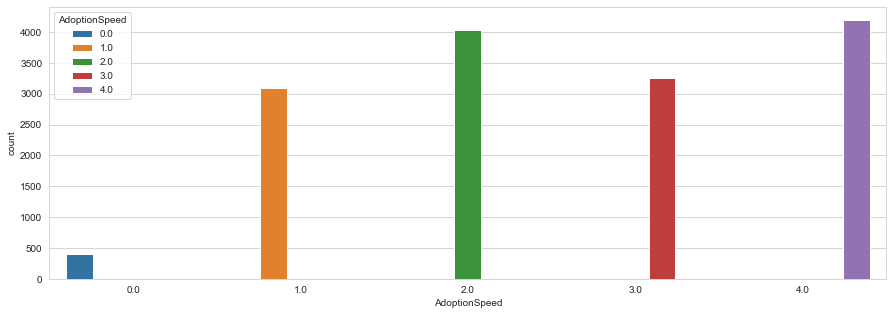

In [54]:
plt.figure(figsize = (15,5))
sns.countplot(data = train,
             x = 'AdoptionSpeed',
             hue = 'AdoptionSpeed')

In [55]:
target_classes = pd.DataFrame(train,
                              index = train['AdoptionSpeed'].sort_values(ascending = False).unique(),
                              columns = ['Adoption Speed Count', 'Adoption Speed %'])
target_classes['Adoption Speed Count'] = train['AdoptionSpeed'].value_counts()
target_classes['Adoption Speed %'] = train['AdoptionSpeed'].value_counts(normalize = True)
target_classes

,Adoption Speed Count,Adoption Speed %
4.0,4197,0.279931
3.0,3259,0.217368
2.0,4037,0.269259
1.0,3090,0.206096
0.0,410,0.027346


> We have one severely unbalanced class. We will need to account for this later on. Only about 2.7% of pets are adopted on the same day.  
>
> The rest of the classes are fairly balanced, including class 4 (pets that are not adopted). Sadly, this is the largest class, with about 28% of animals falling into this category.

###### Do dogs get adopted faster than cats?

In [259]:
# df['Type'] = df['Type'].map(lambda x: 'Dog' if x == 1 else 'Cat')
train['Type'] = train['Type'].map(lambda x: 'Dog' if x == 1 else 'Cat')
# test['Type'] = test['Type'].map(lambda x: 'Dog' if x == 1 else 'Cat')


In [57]:
# sns.countplot(data = df, 
#               x = 'train_test', 
#               hue = 'Type')
# plt.title('')
# plt.xlabel('')
# plt.ylabel('');

In [58]:
# pd.crosstab(df['train_test'], 
#             df['Type'], 
#             normalize = 'index')

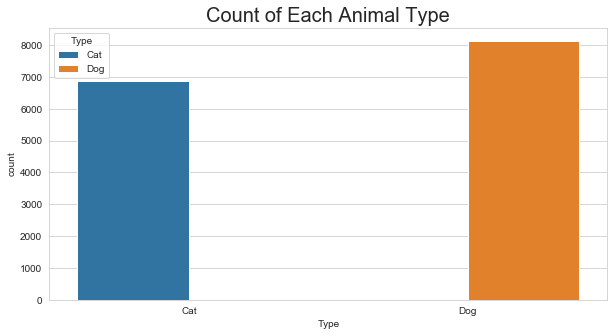

In [263]:
plt.figure(figsize = (10,5))
sns.countplot(data = train,
              x = 'Type',
              hue = 'Type')
plt.title('Count of Each Animal Type', size = 20);

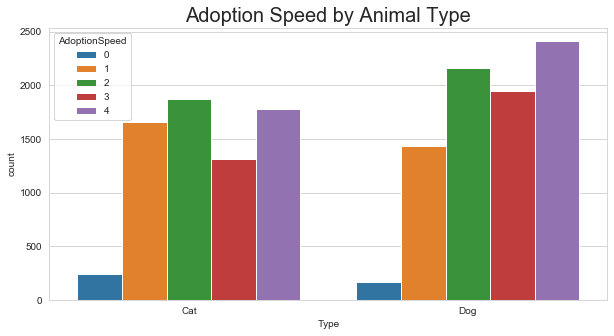

In [266]:
plt.figure(figsize = (10,5))
sns.countplot(data = train, 
              x = 'Type', 
              hue = 'AdoptionSpeed')
plt.title('Adoption Speed by Animal Type', size = 20);

In [267]:
pd.crosstab(train['Type'], 
            train['AdoptionSpeed'], 
            normalize = 'index')

AdoptionSpeed,0,1,2,3,4
Type,,,,,
Cat,0.034980,0.241218,0.272992,0.190934,0.259875
Dog,0.020905,0.176463,0.266109,0.239670,0.296852


###### Names?

In [303]:
# does having a name impact the adoption speed?
name_speed = train[['Name', 'AdoptionSpeed', 'Type']].fillna(0)
name_speed['Name'] = name_speed['Name'].map(lambda x: 'Has Name' if x != 0 else 'No Name')
# test_names = test['Name'].fillna(0).map(lambda x: 'Has Name' if x != 0 else 'No Name')

In [304]:
name_speed['Name'].value_counts(normalize = True)

Has Name    0.916161
No Name     0.083839
Name: Name, dtype: float64

In [305]:
# test_names.value_counts(normalize = True)

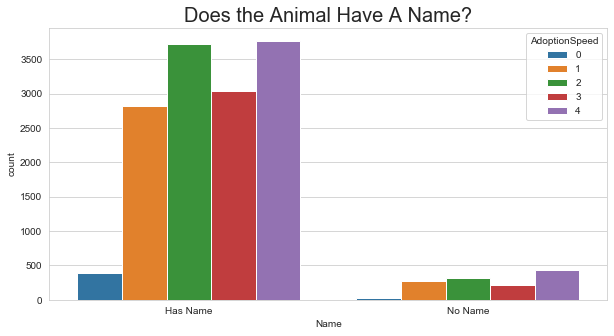

In [308]:
plt.figure(figsize = (10, 5))
sns.countplot(data = name_speed,
              x = 'Name',
              hue = 'AdoptionSpeed')
plt.title('Does the Animal Have A Name?', size = 20);

In [66]:
pd.crosstab(name_speed['Name'],
            name_speed['AdoptionSpeed'],
            normalize = 'index')

AdoptionSpeed,0.0,1.0,2.0,3.0,4.0
Name,,,,,
Has Name,0.027956,0.205227,0.271185,0.221535,0.274097
No Name,0.020684,0.215593,0.248210,0.171838,0.343675


(Has Name    13736
 No Name      1257
 Name: Name, dtype: int64,
 Has Name    0.916161
 No Name     0.083839
 Name: Name, dtype: float64,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 Name                                                           
 Has Name       0.027956  0.205227  0.271185  0.221535  0.274097
 No Name        0.020684  0.215593  0.248210  0.171838  0.343675,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 Type Name                                                      
 Cat  Has Name  0.036622  0.241164  0.274108  0.191108  0.256997
      No Name   0.018092  0.241776  0.261513  0.189145  0.289474
 Dog  Has Name  0.020714  0.175197  0.268742  0.246960  0.288387
      No Name   0.023112  0.191063  0.235747  0.155624  0.394453,
 <seaborn.axisgrid.FacetGrid at 0x1a20866b10>)

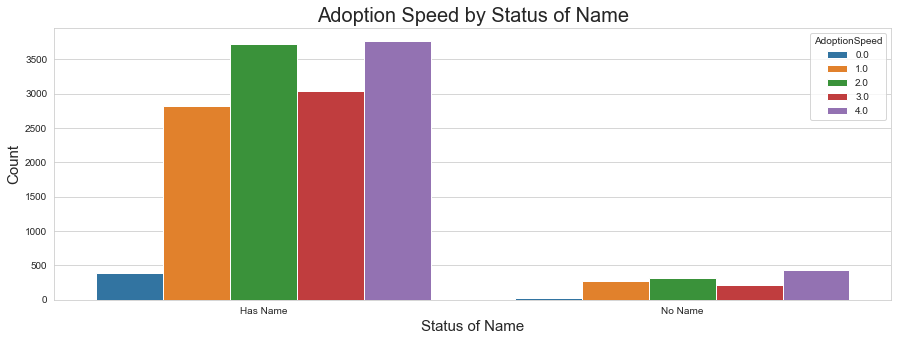

<Figure size 1080x360 with 0 Axes>

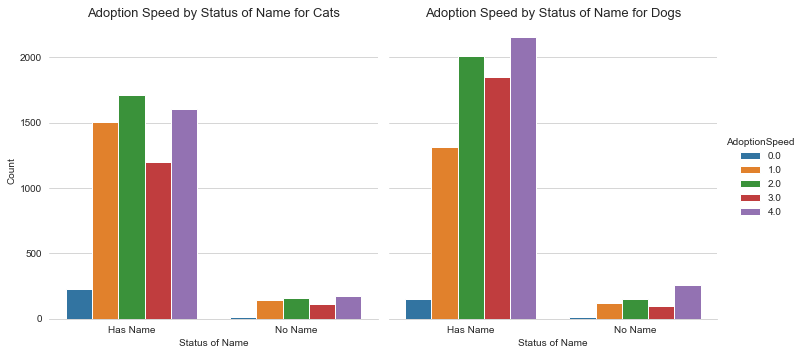

In [67]:
eda(name_speed, 'Name', 'Status of Name')

In [295]:
tvec = TfidfVectorizer(stop_words = 'english')

tfidf_df = pd.DataFrame(tvec.fit_transform(full_data['Name']).toarray(),
                       columns = tvec.get_feature_names())

In [296]:
top_words_tf = {}
for i in tfidf_df.columns:
    top_words_tf[i] =  tfidf_df[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq_tf = pd.DataFrame(sorted(top_words_tf.items(), key = lambda x: x[1], reverse = True))

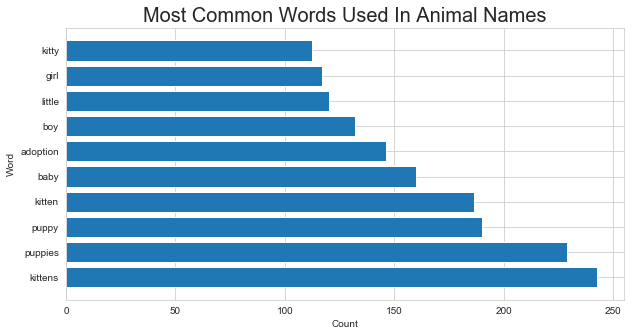

In [309]:
plt.figure(figsize = (10, 5))

# visualize top 10 words
plt.barh(most_freq_tf[0][1:11], most_freq_tf[1][1:11])
plt.title('Most Common Words Used In Animal Names', size = 20)
plt.xlabel('Count')
plt.ylabel('Word');

In [68]:
# useless names?
train[train['Name'].map(lambda x: len(str(x))) <= 2]['Name'].unique()

array(['H3', 'Z3', 'C', 'BB', 'QQ', 'Y1', 'H1', 'D9', 'Y4', 'Z4', 'DD',
       'M2', 'H6', 'D4', 'JJ', 'F1', 'W7', '1F', 'Q1', '6', 'CJ', '3F',
       'KD', 'G1', 'B3', 'Cc', 'F6', 'Mk', 'A5', 'GM', 'D5', 'EE', 'A4',
       'Q4', 'B', 'CC', 'Y7', 'W6', 'A3', 'A1', 'T1', 'W1', 'M4', 'P5',
       'H2', 'GG', 'Y6', 'Z', 'D7', 'B4', 'C2', 'M8', '3', 'G2', 'ML',
       'DJ', 'PP', '8', 'OJ', 'D', 'F2', 'MJ', 'W8', 'W4', 'C1', 'W2',
       'GR', 'B1', '5', 'Fa', 'Y5', 'M', 'F5', 'Y0', 'B2', 'Q6', 'G3',
       '..', 'S1', 'Qu', 'R9', 'W3', 'R7', 'Tj', 'P3', '7', '!', 'RC',
       'Z2', 'Q3', 'A2', 'QD', 'S', '-', 'R6', 'IV', 'Mo', 'W5', 'F8',
       'M6', 'M9', 'Py', 'Rt', 'F9', 'P6', 'AJ', 'Y3', 'D6', 'T2', 'F4',
       'T3', 'YY', '99', 'F7', 'W+', 'D2', '1', '#1', 'S4', '2', 'Am',
       'P', 'P4', 'R5', 'M3', 'R3', 'JD', 'BJ', 'L', 'KC', 'VV', 'M1',
       '!.', 'V6', 'P1', 'J', 'S3', 'A6', 'Cq', 'M5', 'B5', 'J1', 'O',
       '2F', 'Q2', 'Y2', 'AB', 'A', 'Jo', 'ET', 'A9', 'ST', 'Po', 'KK'

In [69]:
useless_names = train[['Name', 'AdoptionSpeed']].copy()
useless_names['Name'] = useless_names['Name'].fillna('0').map(lambda x: 'Useless' if len(x) <= 2 else 'Normal')

In [70]:
pd.crosstab(useless_names['Name'],
            useless_names['AdoptionSpeed'])

AdoptionSpeed,0.0,1.0,2.0,3.0,4.0
Name,,,,,
Normal,380,2771,3664,2972,3733
Useless,30,319,373,287,464


###### Age and Adoption Speeds:

In [71]:
train['Age'].value_counts().sort_values(ascending = False)

2     3503
1     2304
3     1966
4     1109
12     967
      ... 
87       1
86       1
95       1
66       1
43       1
Name: Age, Length: 106, dtype: int64

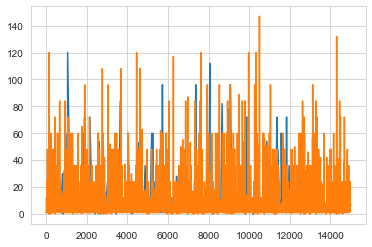

ValueError: x and y must have same first dimension, but have shapes (14993,) and (106,)

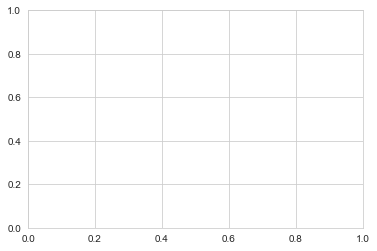

In [279]:
plt.plot(train['Age'], train['Age'].value_counts())

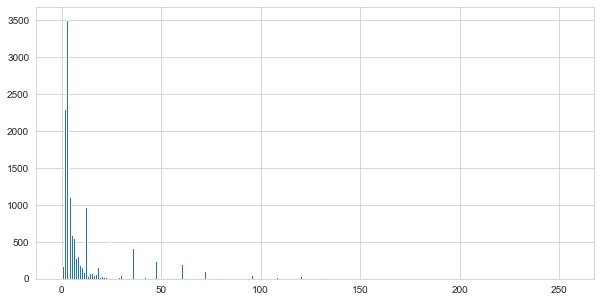

In [283]:
plt.figure(figsize = (10,5))
plt.hist(x = train['Age'],
         bins = 260);

> Most animals are younger.

In [310]:
# https://www.kaggle.com/artgor/exploration-of-data-step-by-step, cell 25
# !pip install plotly
import plotly.offline as py

import plotly.graph_objs as go
data = []
for i in range(5):
    df = train.loc[train['AdoptionSpeed'] == i]

    data.append(go.Scatter(
        x = df['Age'].value_counts().sort_index().index,
        y = df['Age'].value_counts().sort_index().values,
        name = str(i)
    ))
    
layout = go.Layout(dict(title = "Adoption Speed by Age",
                  xaxis = dict(title = 'Age (months)'),
                  yaxis = dict(title = 'Counts'),
                  )
                  )
py.iplot(dict(data=data, layout=layout), filename='basic-line');

In [280]:
plt.figure(figsize = (10, 5))
sns.lineplot(data = train,
              x = 'Age',
              hue = 'AdoptionSpeed')

ValueError: Either both or neither of `x` and `y` must be specified (but try passing to `data`, which is more flexible).

<Figure size 720x360 with 0 Axes>

###### Health:

In [75]:

pd.crosstab(train['Health'],
            train['AdoptionSpeed'],
            normalize = 'index')

AdoptionSpeed,0.0,1.0,2.0,3.0,4.0
Health,,,,,
Healthy,0.027076,0.207142,0.271101,0.217571,0.277110
Minor Injury,0.035343,0.185031,0.220374,0.203742,0.355509
Serious Injury,0.029412,0.058824,0.176471,0.323529,0.411765


(Healthy           14478
 Minor Injury        481
 Serious Injury       34
 Name: Health, dtype: int64,
 Healthy           0.965651
 Minor Injury      0.032082
 Serious Injury    0.002268
 Name: Health, dtype: float64,
 AdoptionSpeed        0.0       1.0       2.0       3.0       4.0
 Health                                                          
 Healthy         0.027076  0.207142  0.271101  0.217571  0.277110
 Minor Injury    0.035343  0.185031  0.220374  0.203742  0.355509
 Serious Injury  0.029412  0.058824  0.176471  0.323529  0.411765,
 AdoptionSpeed             0.0       1.0       2.0       3.0       4.0
 Type Health                                                          
 Cat  Healthy         0.034675  0.242877  0.274838  0.189658  0.257953
      Minor Injury    0.041860  0.200000  0.232558  0.213953  0.311628
      Serious Injury  0.076923  0.076923  0.000000  0.461538  0.384615
 Dog  Healthy         0.020650  0.176928  0.267941  0.241173  0.293308
      Minor Injury    0.

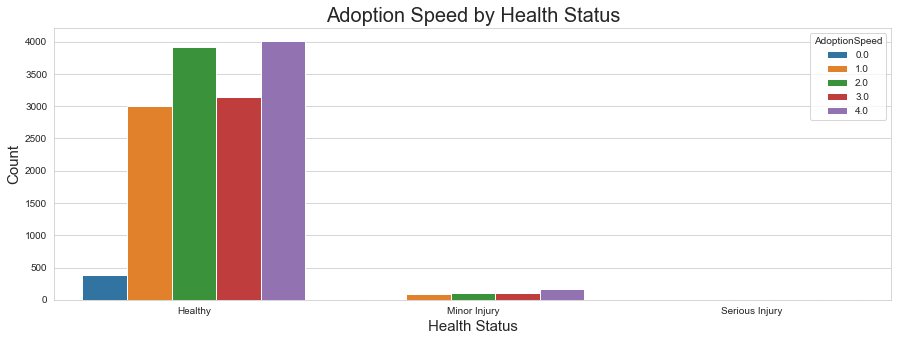

<Figure size 1080x360 with 0 Axes>

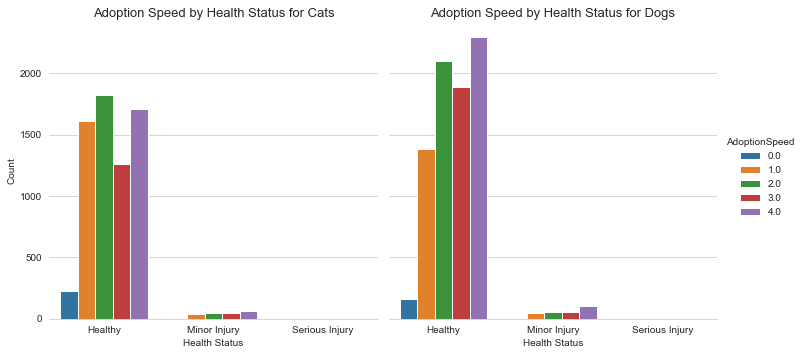

In [76]:
eda(train, 'Health', 'Health Status')

In [77]:
crosstab(train, 'Health')

AdoptionSpeed,0.0,1.0,2.0,3.0,4.0
Health,,,,,
Healthy,0.027076,0.207142,0.271101,0.217571,0.277110
Minor Injury,0.035343,0.185031,0.220374,0.203742,0.355509
Serious Injury,0.029412,0.058824,0.176471,0.323529,0.411765


###### Vaccinated

(No          7227
 Yes         5898
 Not Sure    1868
 Name: Vaccinated, dtype: int64,
 No          0.482025
 Yes         0.393384
 Not Sure    0.124591
 Name: Vaccinated, dtype: float64,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 Vaccinated                                                     
 No             0.028504  0.245883  0.292237  0.201882  0.231493
 Not Sure       0.031049  0.186296  0.241970  0.203961  0.336724
 Yes            0.024754  0.163615  0.249746  0.240590  0.321295,
 AdoptionSpeed         0.0       1.0       2.0       3.0       4.0
 Type Vaccinated                                                  
 Cat  No          0.036835  0.273527  0.286359  0.187262  0.216017
      Not Sure    0.048411  0.228442  0.214826  0.134644  0.373676
      Yes         0.026606  0.177209  0.264056  0.217369  0.314759
 Dog  No          0.016893  0.207353  0.300431  0.222259  0.253064
      Not Sure    0.021541  0.163215  0.256835  0.241922  0.316487
      Yes        

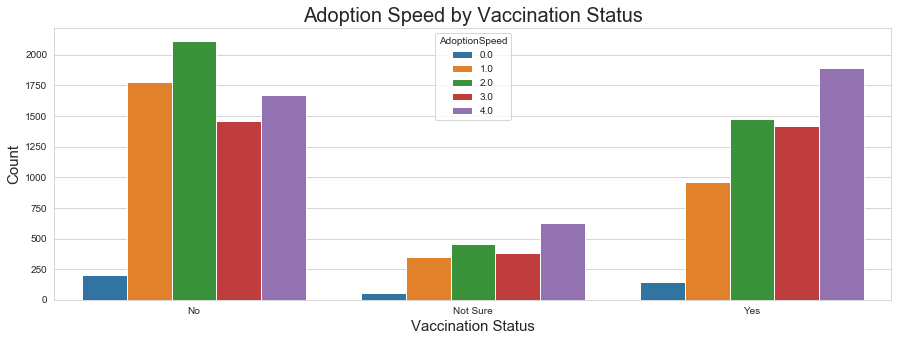

<Figure size 1080x360 with 0 Axes>

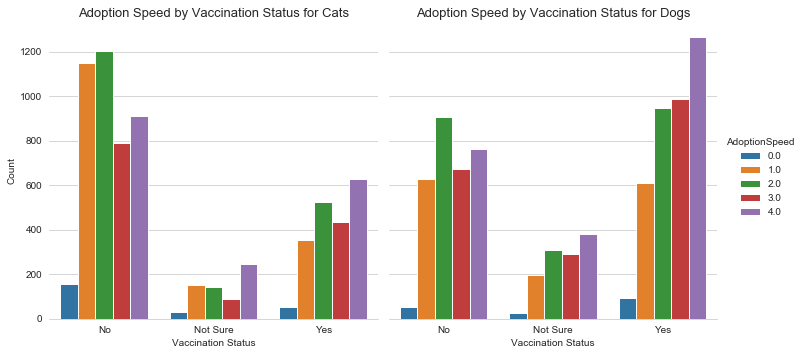

In [78]:
eda(train, 'Vaccinated', 'Vaccination Status')

In [79]:
train['Vaccinated'].value_counts()
# 1 = Yes, 2 = No, 3 = Not Sure

No          7227
Yes         5898
Not Sure    1868
Name: Vaccinated, dtype: int64

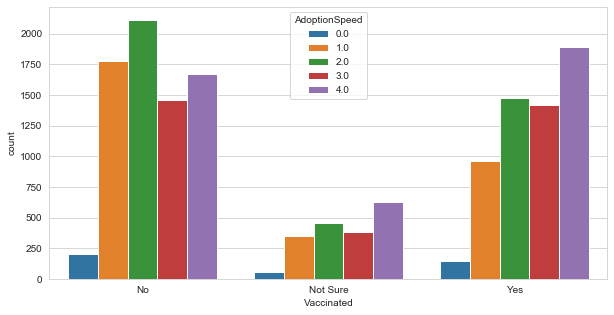

In [80]:
plt.figure(figsize = (10, 5))
sns.countplot(data = train,
              x = 'Vaccinated',
              hue = 'AdoptionSpeed')

In [81]:
pd.crosstab(train['Vaccinated'],
            train['AdoptionSpeed'],
            normalize = 'index')

AdoptionSpeed,0.0,1.0,2.0,3.0,4.0
Vaccinated,,,,,
No,0.028504,0.245883,0.292237,0.201882,0.231493
Not Sure,0.031049,0.186296,0.241970,0.203961,0.336724
Yes,0.024754,0.163615,0.249746,0.240590,0.321295


###### Dewormed:

(Yes         8397
 No          4815
 Not Sure    1781
 Name: Dewormed, dtype: int64,
 Yes         0.560061
 No          0.321150
 Not Sure    0.118789
 Name: Dewormed, dtype: float64,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 Dewormed                                                       
 No             0.030322  0.246729  0.279751  0.189823  0.253375
 Not Sure       0.033127  0.185289  0.234138  0.200449  0.346996
 Yes            0.024413  0.187210  0.270692  0.236751  0.280934,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 Type Dewormed                                                  
 Cat  No        0.038040  0.273592  0.277249  0.175567  0.235552
      Not Sure  0.050325  0.237013  0.207792  0.121753  0.383117
      Yes       0.029906  0.216747  0.281116  0.215038  0.257192
 Dog  No        0.020183  0.211437  0.283037  0.208554  0.276790
      Not Sure  0.024034  0.157940  0.248069  0.242060  0.327897
      Yes       0.020467  0.165984 

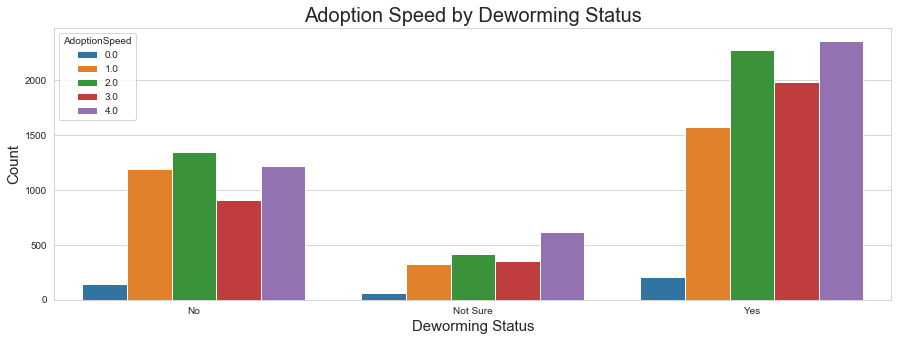

<Figure size 1080x360 with 0 Axes>

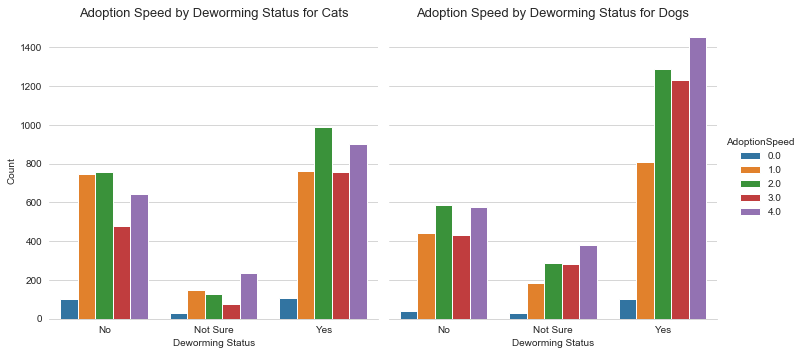

In [82]:
eda(train, 'Dewormed', 'Deworming Status')
# 1 = Yes , 2 = No, 3 = Not Sure

###### Sterilized: 

(No          10077
 Yes          3101
 Not Sure     1815
 Name: Sterilized, dtype: int64,
 No          0.672114
 Yes         0.206830
 Not Sure    0.121056
 Name: Sterilized, dtype: float64,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 Sterilized                                                     
 No             0.026794  0.235983  0.299891  0.223380  0.213953
 Not Sure       0.038567  0.191736  0.197796  0.158678  0.413223
 Yes            0.022573  0.117381  0.211545  0.232183  0.416317,
 AdoptionSpeed         0.0       1.0       2.0       3.0       4.0
 Type Sterilized                                                  
 Cat  No          0.034047  0.270948  0.295617  0.196330  0.203058
      Not Sure    0.054441  0.224928  0.202006  0.138968  0.379656
      Yes         0.027822  0.134340  0.224165  0.198728  0.414944
 Dog  No          0.019915  0.202823  0.303944  0.249033  0.224285
      Not Sure    0.028648  0.170994  0.195166  0.170994  0.434199
      Yes     

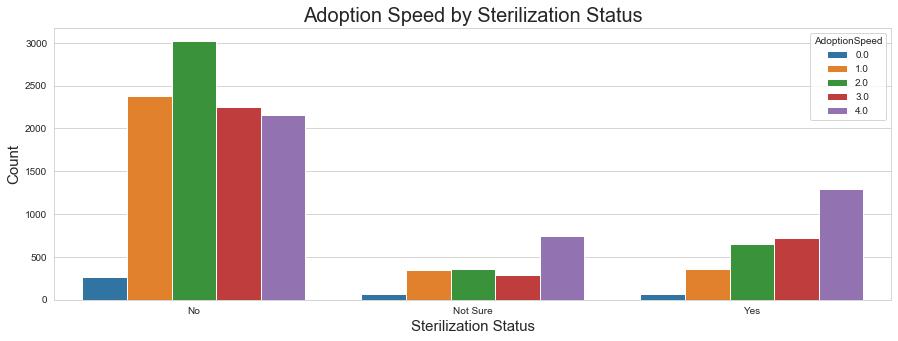

<Figure size 1080x360 with 0 Axes>

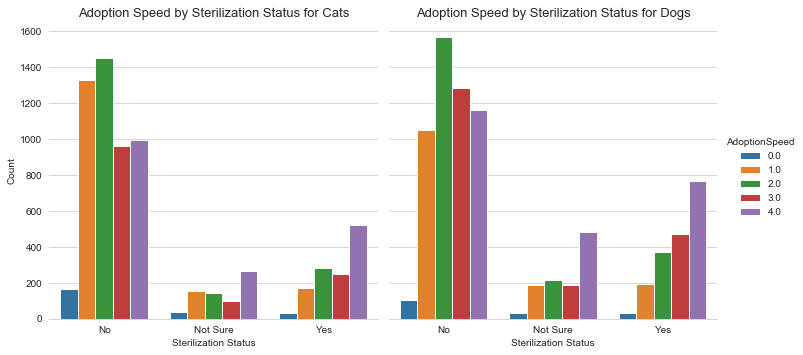

In [83]:
eda(train, 'Sterilized', 'Sterilization Status')

In [84]:
crosstab(train, 'Sterilized')

AdoptionSpeed,0.0,1.0,2.0,3.0,4.0
Sterilized,,,,,
No,0.026794,0.235983,0.299891,0.223380,0.213953
Not Sure,0.038567,0.191736,0.197796,0.158678,0.413223
Yes,0.022573,0.117381,0.211545,0.232183,0.416317


###### Fur Length:

(Short     8808
 Medium    5361
 Long       824
 Name: FurLength, dtype: int64,
 Short     0.587474
 Medium    0.357567
 Long      0.054959
 Name: FurLength, dtype: float64,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 FurLength                                                      
 Long           0.067961  0.308252  0.268204  0.186893  0.168689
 Medium         0.029845  0.221414  0.269353  0.207237  0.272151
 Short          0.022025  0.187216  0.269301  0.226385  0.295073,
 AdoptionSpeed        0.0       1.0       2.0       3.0       4.0
 Type FurLength                                                  
 Cat  Long       0.085586  0.324324  0.247748  0.171171  0.171171
      Medium     0.037720  0.253751  0.265324  0.179597  0.263609
      Short      0.027914  0.225024  0.280118  0.199559  0.267385
 Dog  Long       0.047368  0.289474  0.292105  0.205263  0.165789
      Medium     0.023778  0.196499  0.272457  0.228534  0.278732
      Short      0.016935  0.154530  0

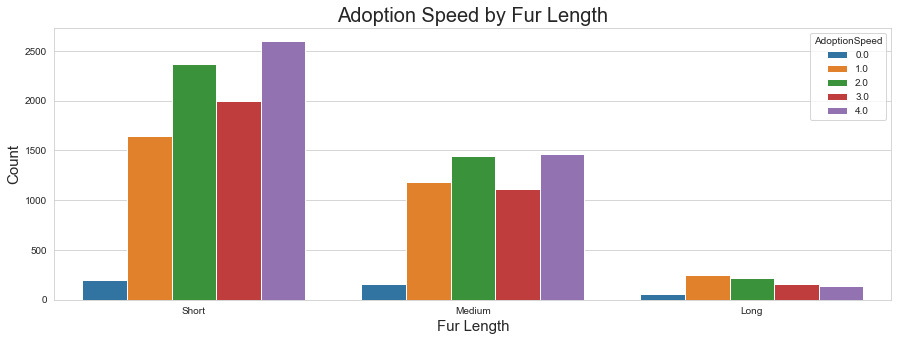

<Figure size 1080x360 with 0 Axes>

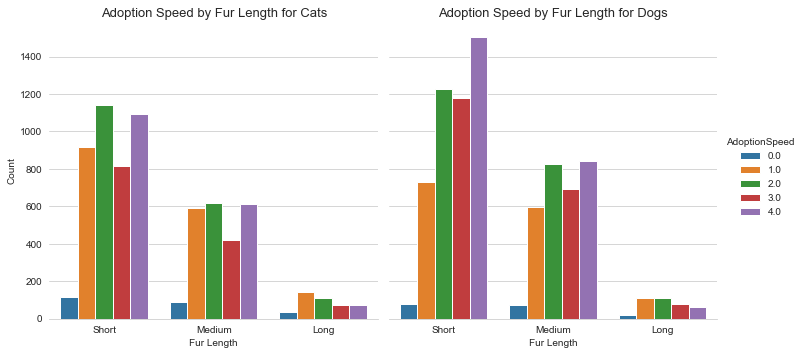

In [85]:

eda(train, 'FurLength', 'Fur Length')
# 1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified

###### Quantity:

(1     11565
 2      1422
 3       726
 4       531
 5       333
 6       185
 7        84
 8        52
 9        33
 10       19
 20       12
 11       10
 12        6
 15        4
 17        3
 16        3
 13        2
 14        2
 18        1
 Name: Quantity, dtype: int64,
 1     0.771360
 2     0.094844
 3     0.048423
 4     0.035417
 5     0.022210
 6     0.012339
 7     0.005603
 8     0.003468
 9     0.002201
 10    0.001267
 20    0.000800
 11    0.000667
 12    0.000400
 15    0.000267
 17    0.000200
 16    0.000200
 13    0.000133
 14    0.000133
 18    0.000067
 Name: Quantity, dtype: float64,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 Quantity                                                       
 1              0.028621  0.210895  0.273498  0.220666  0.266321
 2              0.024613  0.203938  0.254571  0.215893  0.300985
 3              0.027548  0.217631  0.249311  0.203857  0.301653
 4              0.024482  0.199623  0.242938  0.182674  0.35

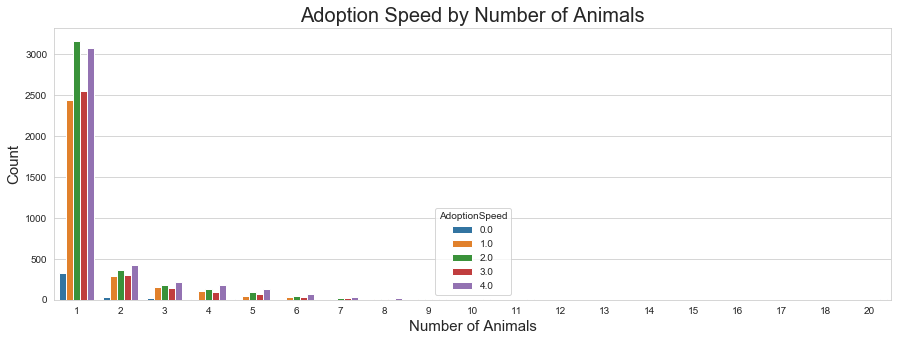

<Figure size 1080x360 with 0 Axes>

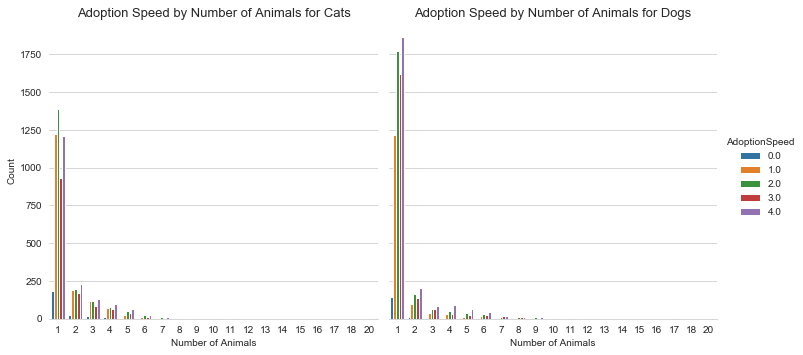

In [86]:
eda(train, 'Quantity', 'Number of Animals')

###### Fee:

(0      12663
 50       468
 100      408
 200      219
 150      162
        ...  
 210        1
 99         1
 330        1
 75         1
 599        1
 Name: Fee, Length: 74, dtype: int64,
 0      0.844594
 50     0.031215
 100    0.027213
 200    0.014607
 150    0.010805
          ...   
 210    0.000067
 99     0.000067
 330    0.000067
 75     0.000067
 599    0.000067
 Name: Fee, Length: 74, dtype: float64,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 Fee                                                            
 0              0.028192  0.206191  0.270868  0.220248  0.274501
 1              0.024390  0.158537  0.195122  0.207317  0.414634
 2              0.000000  1.000000  0.000000  0.000000  0.000000
 5              0.000000  0.458333  0.166667  0.166667  0.208333
 8              0.142857  0.142857  0.285714  0.428571  0.000000
 ...                 ...       ...       ...       ...       ...
 750            0.000000  0.142857  0.571429  0.142857  0.142

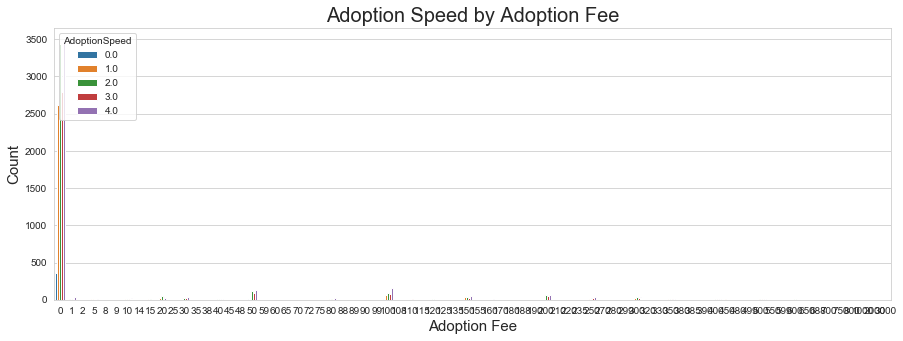

<Figure size 1080x360 with 0 Axes>

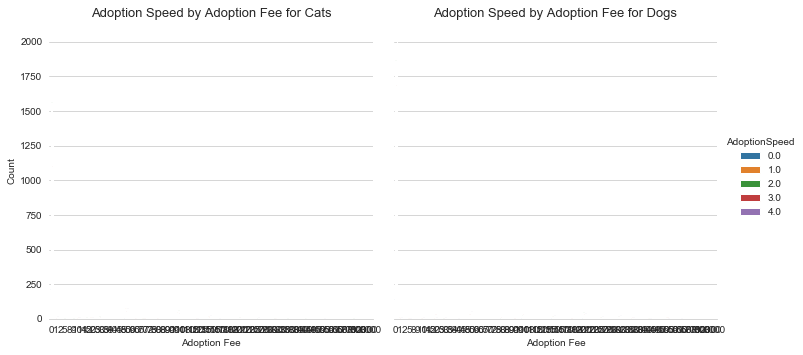

In [87]:
eda(train, 'Fee', 'Adoption Fee')

###### State:

(Selangor           8714
 Kuala Lumpur       3845
 Pulau Pinang        843
 Johor               507
 Perak               420
 Negeri Sembilan     253
 Melaka              137
 Kedah               110
 Pahang               85
 Terengganu           26
 Sabah                22
 Kelantan             15
 Sarawak              13
 Labuan                3
 Name: State, dtype: int64,
 Selangor           0.581205
 Kuala Lumpur       0.256453
 Pulau Pinang       0.056226
 Johor              0.033816
 Perak              0.028013
 Negeri Sembilan    0.016875
 Melaka             0.009138
 Kedah              0.007337
 Pahang             0.005669
 Terengganu         0.001734
 Sabah              0.001467
 Kelantan           0.001000
 Sarawak            0.000867
 Labuan             0.000200
 Name: State, dtype: float64,
 AdoptionSpeed         0.0       1.0       2.0       3.0       4.0
 State                                                            
 Johor            0.045365  0.222880  0.268245  0.20

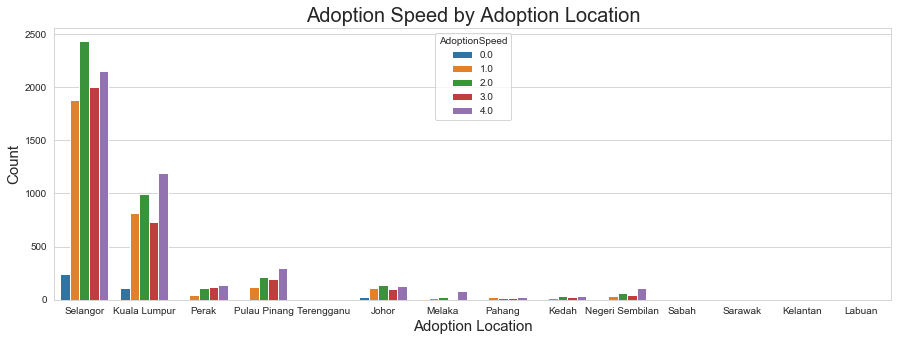

<Figure size 1080x360 with 0 Axes>

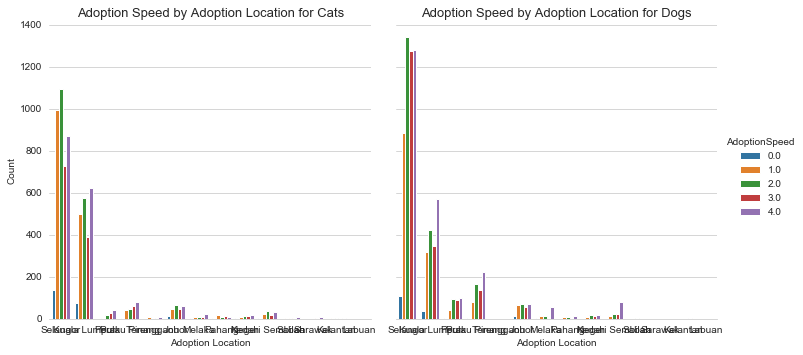

In [88]:
eda(train, 'State', 'Adoption Location')

###### Number of Videos:

(0    14419
 1      417
 2       92
 3       36
 4       15
 5        7
 6        4
 8        2
 7        1
 Name: VideoAmt, dtype: int64,
 0    0.961715
 1    0.027813
 2    0.006136
 3    0.002401
 4    0.001000
 5    0.000467
 6    0.000267
 8    0.000133
 7    0.000067
 Name: VideoAmt, dtype: float64,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 VideoAmt                                                       
 0              0.027048  0.207365  0.267633  0.215272  0.282683
 1              0.038369  0.179856  0.311751  0.261391  0.208633
 2              0.032609  0.184783  0.315217  0.315217  0.152174
 3              0.027778  0.138889  0.361111  0.194444  0.277778
 4              0.000000  0.066667  0.200000  0.333333  0.400000
 5              0.000000  0.142857  0.285714  0.428571  0.142857
 6              0.000000  0.250000  0.000000  0.250000  0.500000
 7              0.000000  0.000000  1.000000  0.000000  0.000000
 8              0.000000  0.000000  0.00000

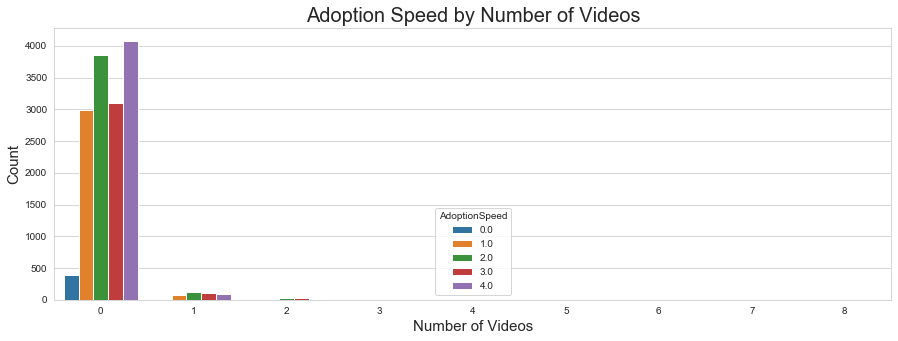

<Figure size 1080x360 with 0 Axes>

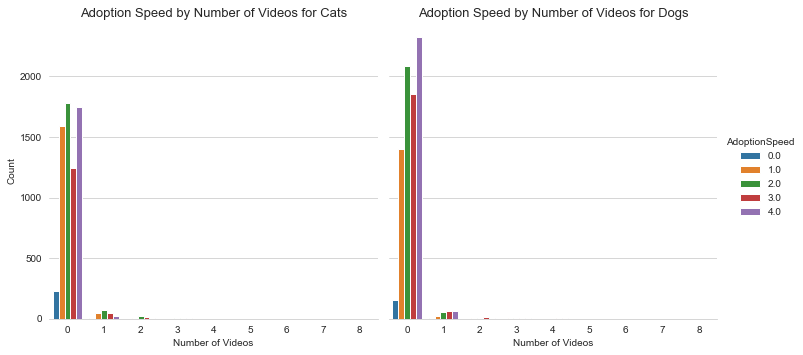

In [89]:
eda(train, 'VideoAmt', 'Number of Videos')

###### Number of Photos:

(1.0     3075
 2.0     2518
 3.0     2511
 5.0     2147
 4.0     1881
 6.0      621
 7.0      432
 0.0      341
 8.0      314
 9.0      231
 10.0     190
 11.0     184
 12.0      97
 13.0      86
 14.0      78
 15.0      50
 16.0      39
 17.0      27
 20.0      25
 19.0      20
 30.0      19
 18.0      18
 21.0      16
 24.0      15
 23.0      12
 26.0      10
 22.0       9
 25.0       8
 28.0       7
 27.0       6
 29.0       6
 Name: PhotoAmt, dtype: int64,
 1.0     0.205096
 2.0     0.167945
 3.0     0.167478
 5.0     0.143200
 4.0     0.125459
 6.0     0.041419
 7.0     0.028813
 0.0     0.022744
 8.0     0.020943
 9.0     0.015407
 10.0    0.012673
 11.0    0.012272
 12.0    0.006470
 13.0    0.005736
 14.0    0.005202
 15.0    0.003335
 16.0    0.002601
 17.0    0.001801
 20.0    0.001667
 19.0    0.001334
 30.0    0.001267
 18.0    0.001201
 21.0    0.001067
 24.0    0.001000
 23.0    0.000800
 26.0    0.000667
 22.0    0.000600
 25.0    0.000534
 28.0    0.000467
 27.0    0.00

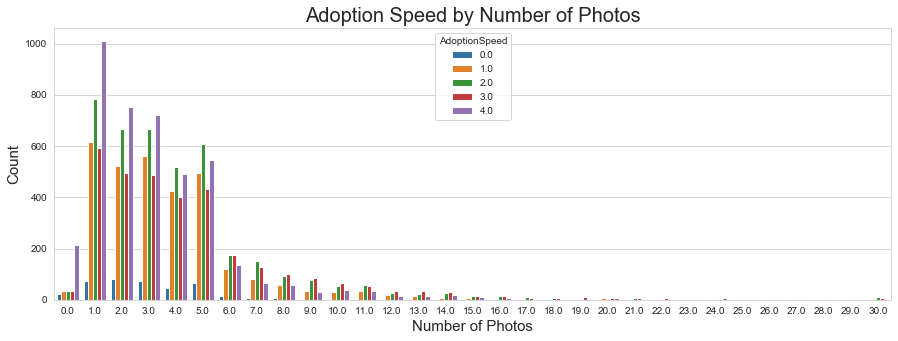

<Figure size 1080x360 with 0 Axes>

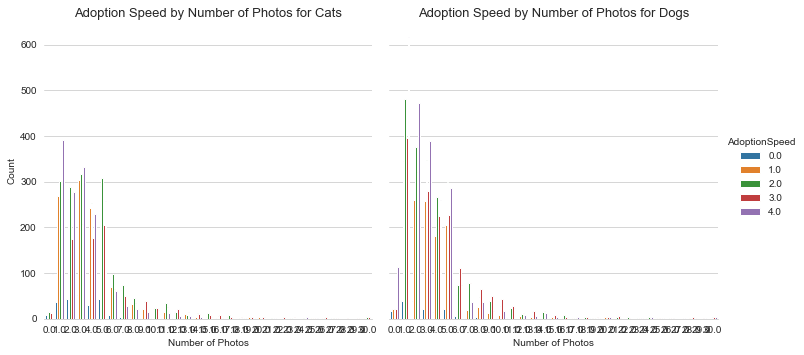

In [90]:
eda(train, 'PhotoAmt', 'Number of Photos')

###### Maturity Size:

(Medium         10305
 Small           3395
 Large           1260
 Extra Large       33
 Name: MaturitySize, dtype: int64,
 Medium         0.687321
 Small          0.226439
 Large          0.084039
 Extra Large    0.002201
 Name: MaturitySize, dtype: float64,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 MaturitySize                                                   
 Extra Large    0.060606  0.212121  0.333333  0.303030  0.090909
 Large          0.034127  0.241270  0.242063  0.196825  0.285714
 Medium         0.021931  0.185250  0.275303  0.229015  0.288501
 Small          0.040943  0.256259  0.260383  0.188807  0.253608,
 AdoptionSpeed           0.0       1.0       2.0       3.0       4.0
 Type MaturitySize                                                  
 Cat  Extra Large   0.181818  0.090909  0.090909  0.363636  0.272727
      Large         0.044000  0.272000  0.226000  0.182000  0.276000
      Medium        0.030397  0.222834  0.283629  0.196027  0.267113
    

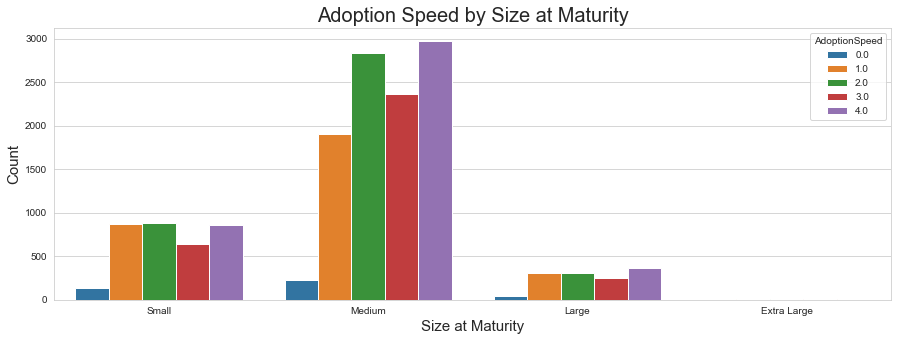

<Figure size 1080x360 with 0 Axes>

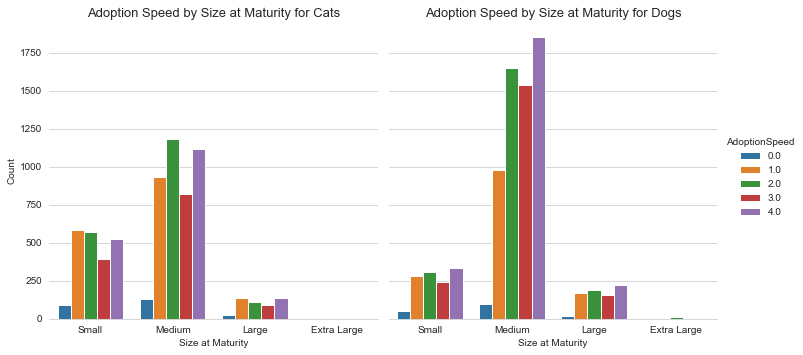

In [91]:

eda(train, 'MaturitySize', 'Size at Maturity')
#1 = Small, 

In [92]:
crosstab(train, 'MaturitySize')

AdoptionSpeed,0.0,1.0,2.0,3.0,4.0
MaturitySize,,,,,
Extra Large,0.060606,0.212121,0.333333,0.303030,0.090909
Large,0.034127,0.241270,0.242063,0.196825,0.285714
Medium,0.021931,0.185250,0.275303,0.229015,0.288501
Small,0.040943,0.256259,0.260383,0.188807,0.253608


###### Color 1:

(Black     7427
 Brown     3750
 Golden     947
 Cream      884
 Gray       684
 White      667
 Yellow     634
 Name: Color1, dtype: int64,
 Black     0.495365
 Brown     0.250117
 Golden    0.063163
 Cream     0.058961
 Gray      0.045621
 White     0.044487
 Yellow    0.042286
 Name: Color1, dtype: float64,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 Color1                                                         
 Black          0.023293  0.201697  0.274135  0.219873  0.281002
 Brown          0.031733  0.183733  0.254933  0.227733  0.301867
 Cream          0.038462  0.248869  0.269231  0.209276  0.234163
 Golden         0.030623  0.222809  0.300950  0.194298  0.251320
 Gray           0.042398  0.228070  0.285088  0.194444  0.250000
 White          0.019490  0.263868  0.272864  0.187406  0.256372
 Yellow         0.020505  0.220820  0.228707  0.228707  0.301262,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 Type Color1                         

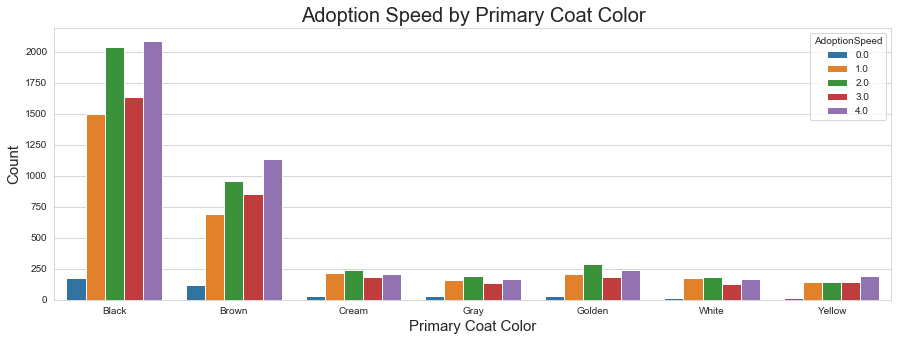

<Figure size 1080x360 with 0 Axes>

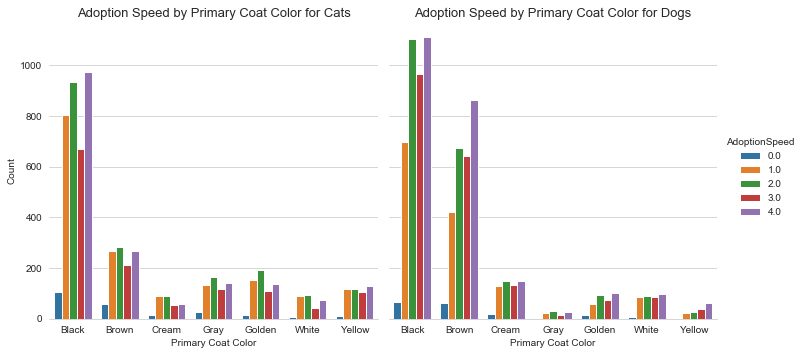

In [93]:
eda(train, 'Color1', 'Primary Coat Color')

(White     3438
 Brown     3313
 Cream     1128
 Gray      1063
 Yellow     870
 Golden     710
 Name: Color2, dtype: int64,
 White     0.326744
 Brown     0.314864
 Cream     0.107204
 Gray      0.101026
 Yellow    0.082684
 Golden    0.067478
 Name: Color2, dtype: float64,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 Color2                                                         
 Brown          0.024147  0.182010  0.284938  0.229701  0.279203
 Cream          0.038121  0.210106  0.280142  0.212766  0.258865
 Golden         0.022535  0.223944  0.247887  0.221127  0.284507
 Gray           0.040452  0.244591  0.269050  0.192850  0.253057
 White          0.028505  0.217859  0.267888  0.227167  0.258581
 Yellow         0.020690  0.186207  0.278161  0.200000  0.314943,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 Type Color2                                                    
 Cat  Brown     0.036847  0.213920  0.269191  0.180143  0.299898
      Cr

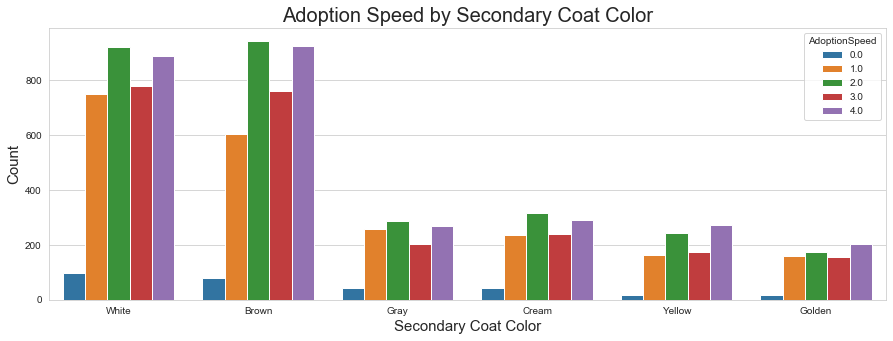

<Figure size 1080x360 with 0 Axes>

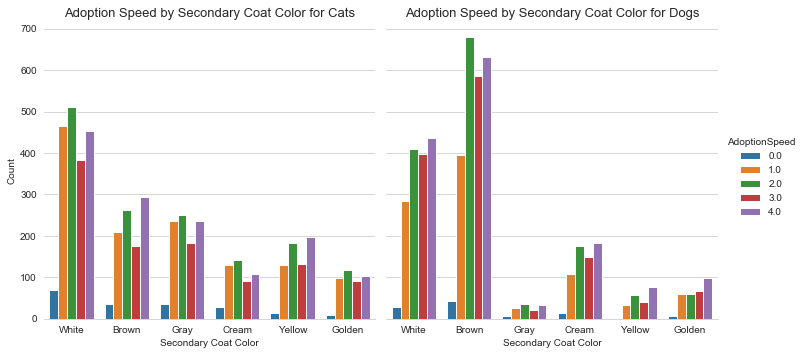

In [94]:
eda(train[train['Color2'] != 'NA'], 'Color2', 'Secondary Coat Color')

(White     3221
 Cream      417
 Gray       378
 Yellow     198
 Golden     175
 Name: Color3, dtype: int64,
 White     0.733880
 Cream     0.095010
 Gray      0.086124
 Yellow    0.045113
 Golden    0.039872
 Name: Color3, dtype: float64,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 Color3                                                         
 Cream          0.035971  0.237410  0.225420  0.225420  0.275779
 Golden         0.017143  0.228571  0.234286  0.194286  0.325714
 Gray           0.026455  0.222222  0.304233  0.195767  0.251323
 White          0.031978  0.201490  0.276622  0.210804  0.279106
 Yellow         0.025253  0.146465  0.242424  0.207071  0.378788,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 Type Color3                                                    
 Cat  Cream     0.051613  0.329032  0.238710  0.141935  0.238710
      Golden    0.023256  0.209302  0.232558  0.186047  0.348837
      Gray      0.027692  0.233846  0.307692

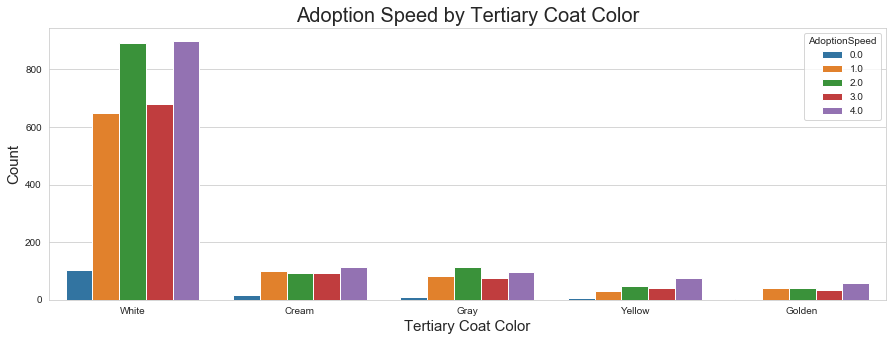

<Figure size 1080x360 with 0 Axes>

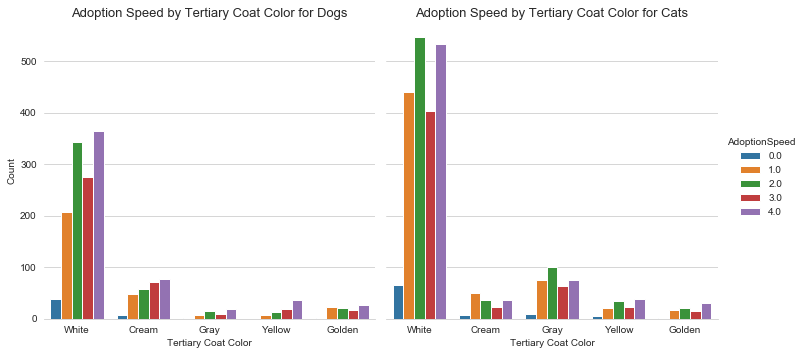

In [95]:
eda(train[train['Color3'] != 'NA'], 'Color3', 'Tertiary Coat Color')

(Multi-Colored    10522
 Solid             4471
 Name: solid_color, dtype: int64,
 Multi-Colored    0.701794
 Solid            0.298206
 Name: solid_color, dtype: float64,
 AdoptionSpeed       0.0       1.0       2.0       3.0       4.0
 solid_color                                                    
 Multi-Colored  0.028322  0.206235  0.274187  0.220300  0.270956
 Solid          0.025050  0.205771  0.257660  0.210467  0.301051,
 AdoptionSpeed            0.0       1.0       2.0       3.0       4.0
 Type solid_color                                                    
 Cat  Multi-Colored  0.036458  0.235491  0.272693  0.196615  0.258743
      Solid          0.029630  0.261953  0.274074  0.170370  0.263973
 Dog  Multi-Colored  0.019821  0.175670  0.275748  0.245045  0.283716
      Solid          0.022773  0.177830  0.249498  0.230409  0.319491,
 <seaborn.axisgrid.FacetGrid at 0x1a283a5f50>)

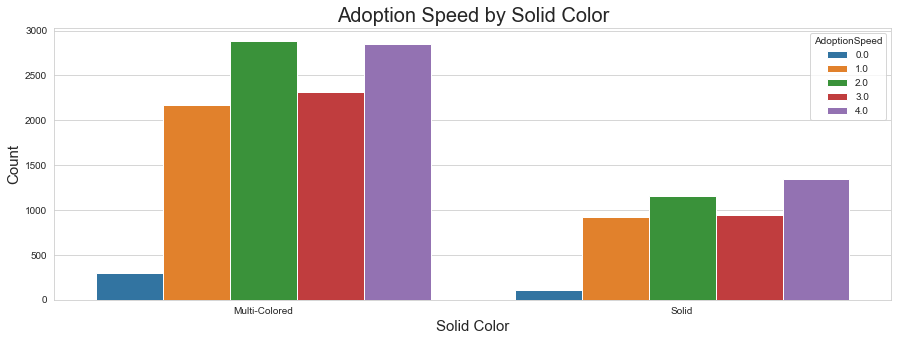

<Figure size 1080x360 with 0 Axes>

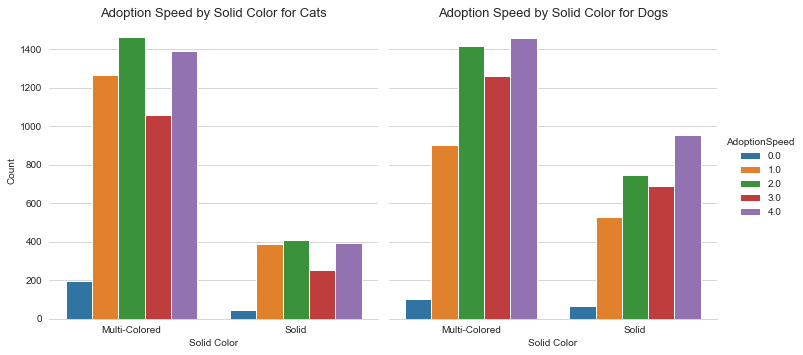

In [96]:
# one coat vs multi-colored
eda(train, 'solid_color', 'Solid Color')


(Brown                1460
 BlackBrown           1417
 BlackWhite           1375
 BlackBrownWhite      1159
 Black                1002
                      ... 
 BlackGoldenYellow      14
 GoldenCreamGray         9
 YellowCreamGray         7
 YellowGray              7
 GoldenYellowGray        5
 Name: coat, Length: 63, dtype: int64,
 Brown                0.097379
 BlackBrown           0.094511
 BlackWhite           0.091709
 BlackBrownWhite      0.077303
 Black                0.066831
                        ...   
 BlackGoldenYellow    0.000934
 GoldenCreamGray      0.000600
 YellowCreamGray      0.000467
 YellowGray           0.000467
 GoldenYellowGray     0.000333
 Name: coat, Length: 63, dtype: float64,
 AdoptionSpeed          0.0       1.0       2.0       3.0       4.0
 coat                                                              
 Black             0.012974  0.181637  0.262475  0.211577  0.331337
 BlackBrown        0.013409  0.167255  0.302047  0.258998  0.258292
 BlackBrow

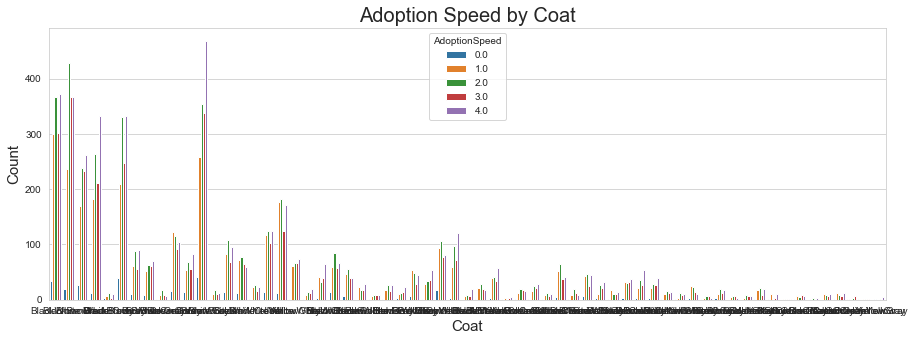

<Figure size 1080x360 with 0 Axes>

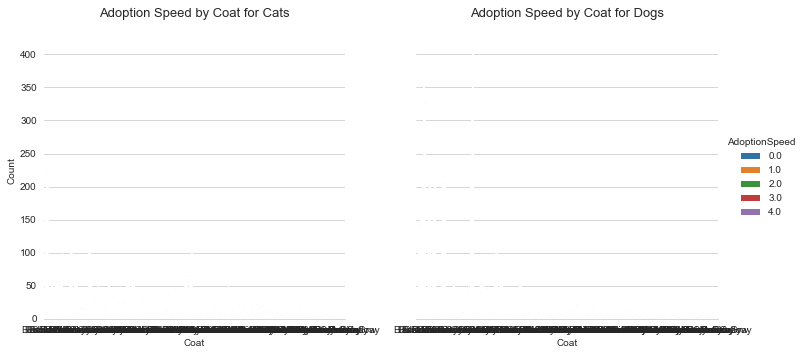

In [97]:
# coat combinations?
eda(train, 'coat_combo', 'Coat')

###### Breed:

In [248]:
top_breeds_tf = {}
for i in full_data['Breed1']:
    top_breeds_tf[i] =  full_data['Breed1'][i].sum()
    
# top_words to dataframe sorted by highest occurance
# most_freq_tf = pd.DataFrame(sorted(top_breeds_tf.items(), key = lambda x: x[1], reverse = True))

KeyError: 'Tabby'

(Mixed Breed              5927
 Domestic Short Hair      3634
 Domestic Medium Hair     1258
 Tabby                     342
 Domestic Long Hair        296
                          ... 
 Sphynx (hairless cat)       1
 Bedlington Terrier          1
 Spaniel                     1
 Irish Terrier               1
 Foxhound                    1
 Name: Breed1, Length: 176, dtype: int64,
 Mixed Breed              0.395318
 Domestic Short Hair      0.242380
 Domestic Medium Hair     0.083906
 Tabby                    0.022811
 Domestic Long Hair       0.019743
                            ...   
 Sphynx (hairless cat)    0.000067
 Bedlington Terrier       0.000067
 Spaniel                  0.000067
 Irish Terrier            0.000067
 Foxhound                 0.000067
 Name: Breed1, Length: 176, dtype: float64,
 AdoptionSpeed                   0.0       1.0   2.0   3.0       4.0
 Breed1                                                             
 Abyssinian                 0.035714  0.178571  0.

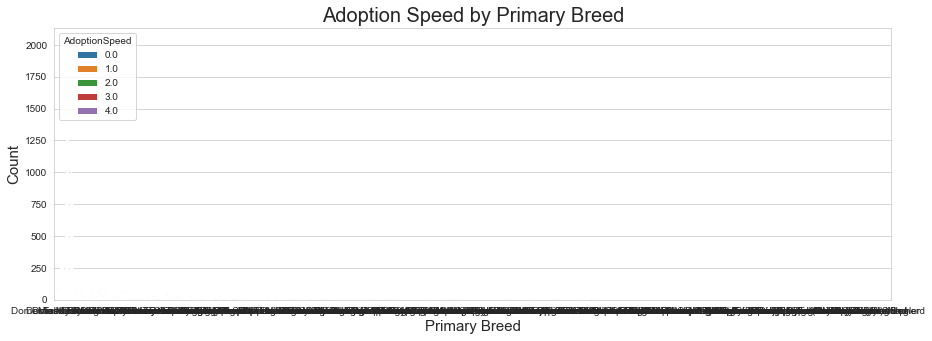

<Figure size 1080x360 with 0 Axes>

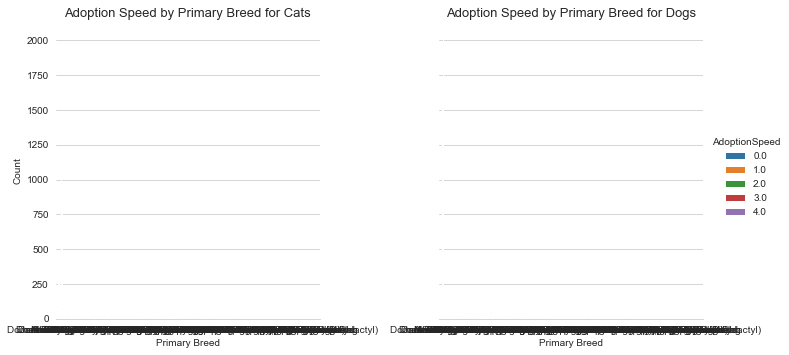

In [98]:
eda(train, 'Breed1', 'Primary Breed')

(NA                           10762
 Mixed Breed                   1727
 Domestic Short Hair            599
 Domestic Medium Hair           321
 Tabby                          138
                              ...  
 Australian Terrier               1
 Papillon                         1
 Yellow Labrador Retriever        1
 Lowchen                          1
 Akbash                           1
 Name: Breed2, Length: 135, dtype: int64,
 NA                           0.717802
 Mixed Breed                  0.115187
 Domestic Short Hair          0.039952
 Domestic Medium Hair         0.021410
 Tabby                        0.009204
                                ...   
 Australian Terrier           0.000067
 Papillon                     0.000067
 Yellow Labrador Retriever    0.000067
 Lowchen                      0.000067
 Akbash                       0.000067
 Name: Breed2, Length: 135, dtype: float64,
 AdoptionSpeed              0.0  1.0  2.0  3.0  4.0
 Breed2                              

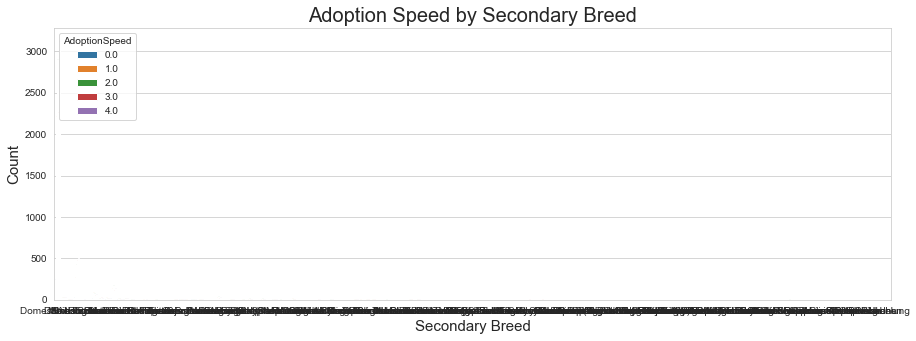

<Figure size 1080x360 with 0 Axes>

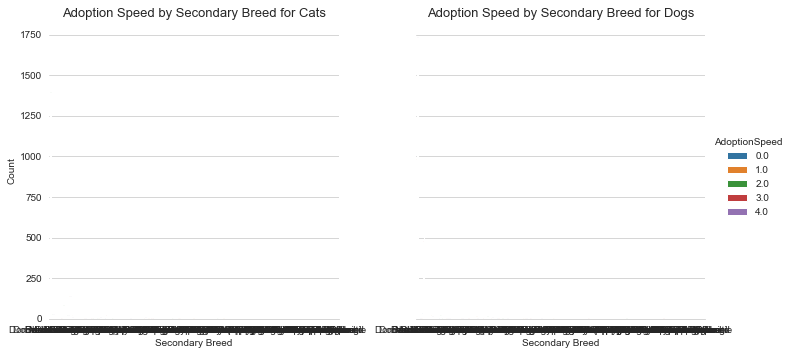

In [99]:
eda(train, 'Breed2', 'Secondary Breed')

###### Descriptions:

In [238]:
tvec = TfidfVectorizer(stop_words = 'english')

tfidf_df = pd.DataFrame(tvec.fit_transform(full_data['Description']).toarray(),
                       columns = tvec.get_feature_names())

In [244]:
top_words_tf = {}
for i in tfidf_df.columns:
    top_words_tf[i] =  tfidf_df[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq_tf = pd.DataFrame(sorted(top_words_tf.items(), key = lambda x: x[1], reverse = True))

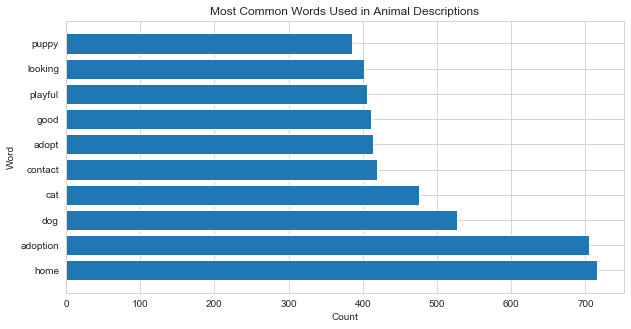

In [246]:
plt.figure(figsize = (10, 5))

# visualize top 10 words
plt.barh(most_freq_tf[0][:10], most_freq_tf[1][:10])
plt.title('Most Common Words Used in Animal Descriptions')
plt.xlabel('Count')
plt.ylabel('Word');

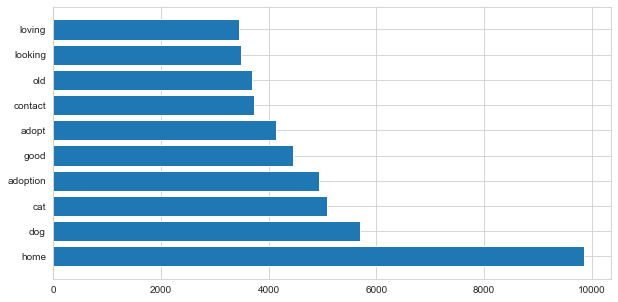

In [241]:
cvec = CountVectorizer(stop_words = 'english')

cvec_df = pd.DataFrame(cvec.fit_transform(full_data['Description']).toarray(),
                       columns = cvec.get_feature_names())

top_words_tf = {}
for i in cvec_df.columns:
    top_words_tf[i] =  cvec_df[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq_tf = pd.DataFrame(sorted(top_words_tf.items(), key = lambda x: x[1], reverse = True))

plt.figure(figsize = (10, 5))

# visualize top 10 words
plt.barh(most_freq_tf[0][:10], most_freq_tf[1][:10]);

###### Heatmaps

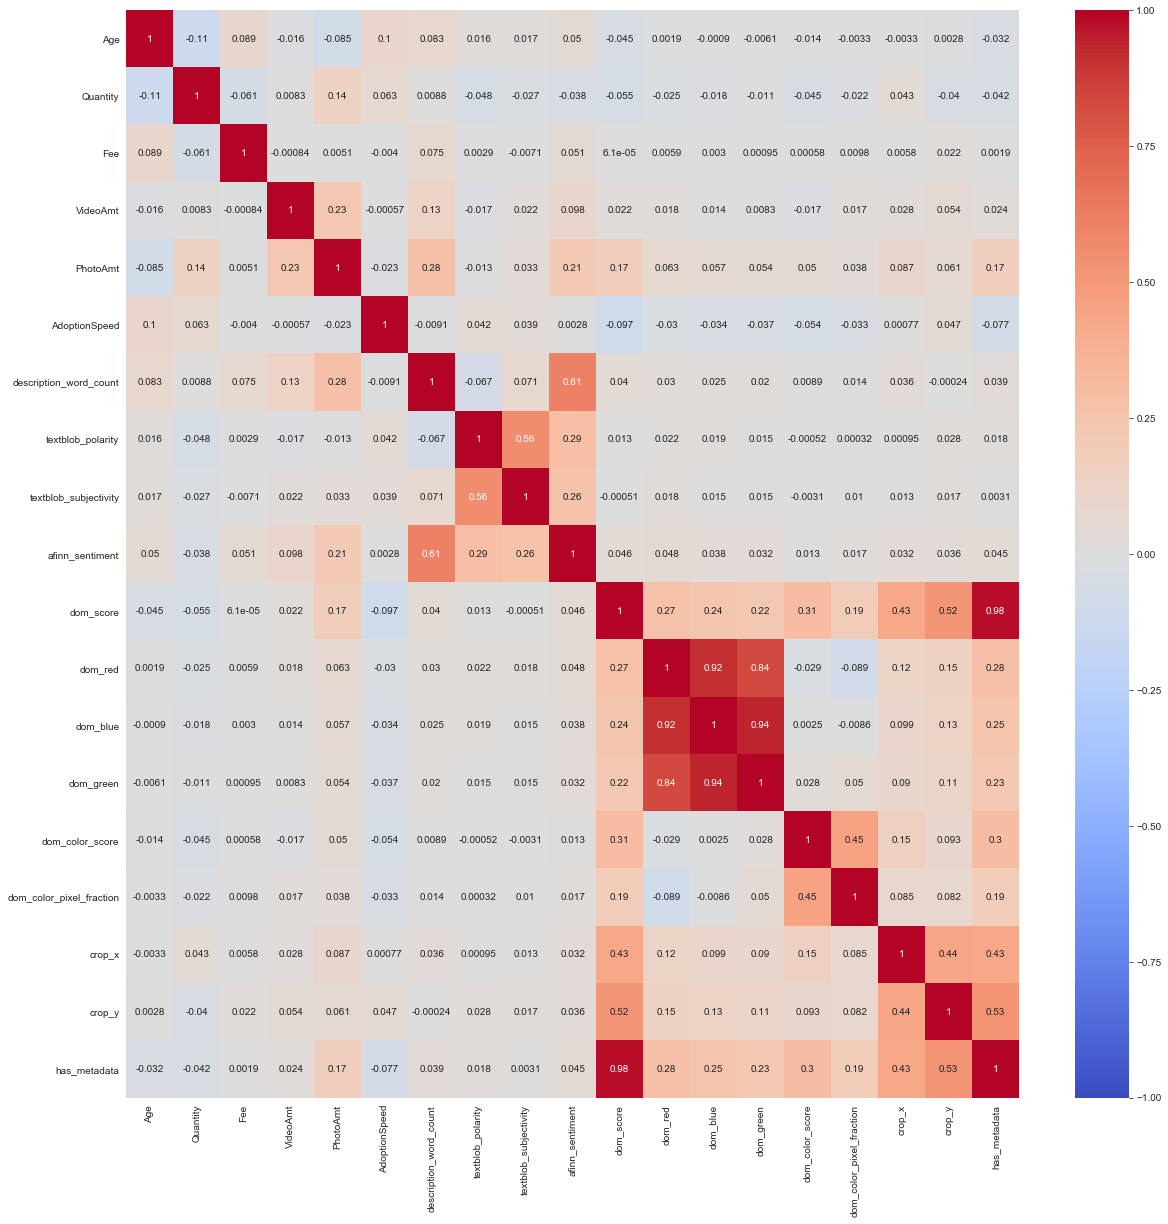

In [100]:
plt.figure(figsize = (20,20))
sns.heatmap(train.corr(),
           vmin = -1,
           vmax = 1,
           cmap = 'coolwarm',
           annot = True);

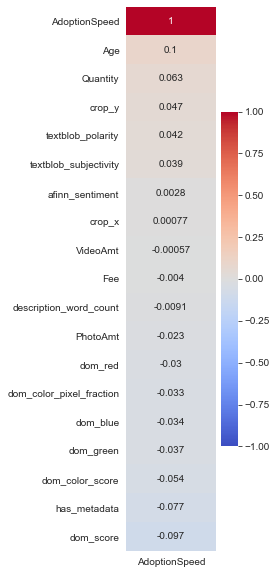

In [101]:
plt.figure(figsize = (2, 10))
sns.heatmap(train.corr()[['AdoptionSpeed']].sort_values('AdoptionSpeed',ascending = False),
           vmin = -1,
           vmax = 1,
           cmap = 'coolwarm',
           annot = True);

In [270]:
full_data.loc[full_data['AdoptionSpeed'] == 0, ['Name', 'PetID']]

,Name,PetID
1,No Name Yet,6296e909a
75,Coco,259b10a3e
106,SYLVESTER,19b1f4263
170,Sunset,b9590d4de
259,Chanelle,1c59cecac
...,...,...
14866,Cotton,72ae87d2b
14907,Milo,03f217352
14923,Lab Mix 3,6097a5c1d
14952,Abg Long,26a07719d
